### 603 code

### Question 1

# A)

In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from dateutil.relativedelta import *
from pandas.tseries.offsets import *
from scipy import stats
import math
%matplotlib inline

In [ ]:
try:
    import psycopg2
except ImportError:
    !pip install psycopg2

In [3]:
try:
    import wrds
except ImportError:
    !pip install wrds
    

In [4]:
try:
    import cvxopt as opt
except ImportError:
    !pip install cvxopt

In [5]:
 from cvxopt import blas, solvers
    
solvers.options['show_progress']=False
    
import scipy.optimize as sco

In [6]:
conn = wrds.Connection()

Enter your WRDS username [bartonf]:barton
Enter your password:········
WRDS recommends setting up a .pgpass file.
You can find more info here:
https://www.postgresql.org/docs/9.5/static/libpq-pgpass.html.
Loading library list...
Done


In [7]:
# Dowload the data from the fama french factors library to be able to find the 
# market return for later beta calculation 
stat="""
Select rf, mktrf
From ff.factors_monthly
Where date between '2008-07-31' and '2019-01-01'
"""
datareg=conn.raw_sql(stat)
datareg1=pd.DataFrame(datareg, columns=['rf','mktrf'])
datareg1.head()

,rf,mktrf
0,0.0013,0.0153
1,0.0015,-0.0924
2,0.0008,-0.1723
3,0.0003,-0.0786
4,0.0000,0.0174


In [8]:
# Find the last riskfree rate for the later optimal porfolio calculation
lastrfrate=datareg1.iloc[:,0].mean()
lastrfrate

0.0002928571428571429

In [41]:
# Dowload the relevant data for our 50 selected stocks on a monthly period

perm={'permnos':('22592','81540','14593','83469','83443','77605','29938','20750',
                 '77369','31500','86356','82642','11850','36768','62228',
                 '12060','90900','77274','39571','52695','23819','87394',
                 '59328','89960','50876','80054','10107','89781','25590',
                 '80539','87179','57665','63706','86580','35107','13856',
                 '62359','11043','50017','89453','46922','91556',
                 '64805','63765','75607','86810','90979','92655','65875','76201')}



      
statement="""
SELECT cusip, permno, date, ret, prc
FROM crsp.msf
WHERE permno in %(permnos)s
and date between '2008-07-31' and '2019-01-01'
"""

data=conn.raw_sql(statement, params=perm)
data1=pd.DataFrame(data, columns=['cusip','permno','date','ret','prc'])
data1.head()

,cusip,permno,date,ret,prc
0,59491810,10107.0,2008-07-31,-0.065067,25.719999
1,59491810,10107.0,2008-08-29,0.065319,27.290001
2,59491810,10107.0,2008-09-30,-0.021986,26.690001
3,59491810,10107.0,2008-10-31,-0.163357,22.330000
4,59491810,10107.0,2008-11-28,-0.088670,20.219999


In [42]:
permtest = pd.DataFrame(perm)
permtest.sort_values(by=['permnos'])
permtest.count()

permnos    50
dtype: int64

In [43]:
#pd.set_option('display.max_columns',500)

In [44]:
# Transpose the table to have it reverse sorted by date
datasetcleaned=data.set_index('date')
datagoodorder=datasetcleaned.pivot(columns='permno', values='prc')
datagoodorder.tail()
df = pd.DataFrame(datagoodorder)
len(df.columns)

50

Text(0,0.5,'price in $')

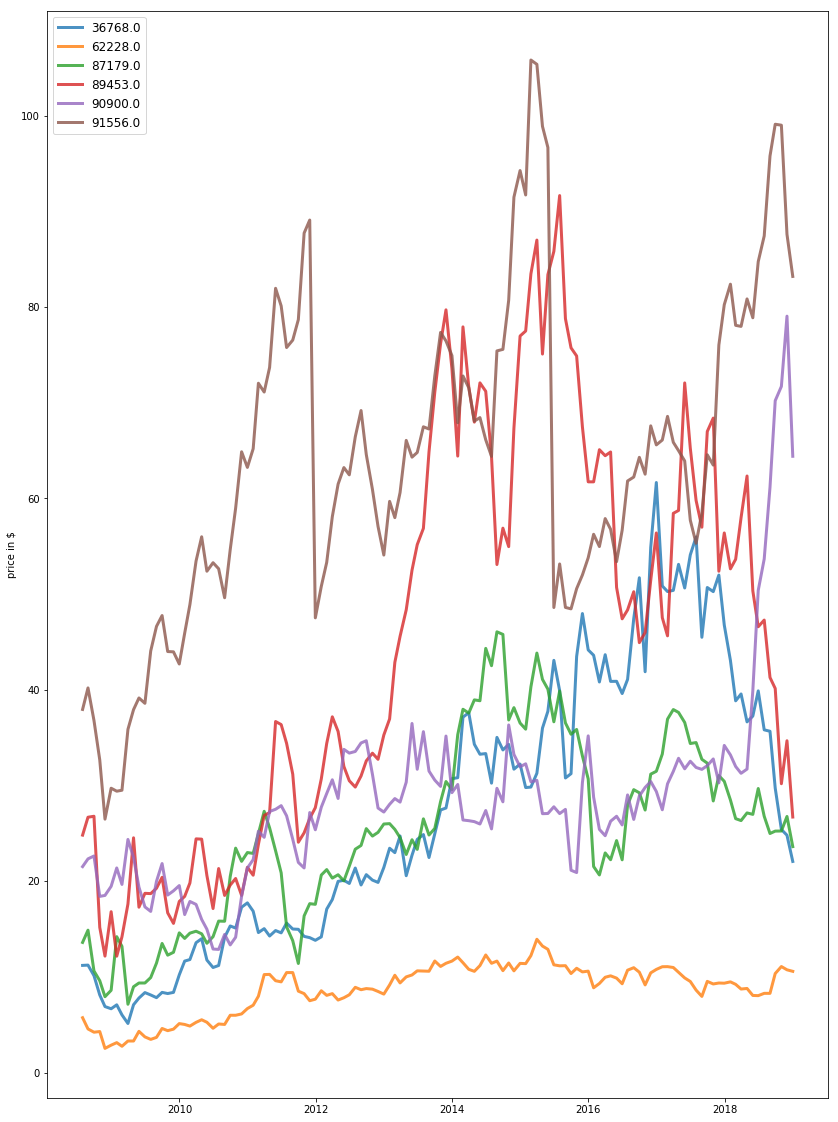

In [13]:
# First have a look at a scatter plot to see a chart of our 50 portfolio. 
# Remark: bershire hathaway share is the most expensive one in our portfolio
#         Some stocks had some stocks splits 
plt.figure(figsize=(14, 20))
for c in datagoodorder.columns.values:
    plt.plot(datagoodorder.index, datagoodorder[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('price in $')

Text(0,0.5,'daily returns')

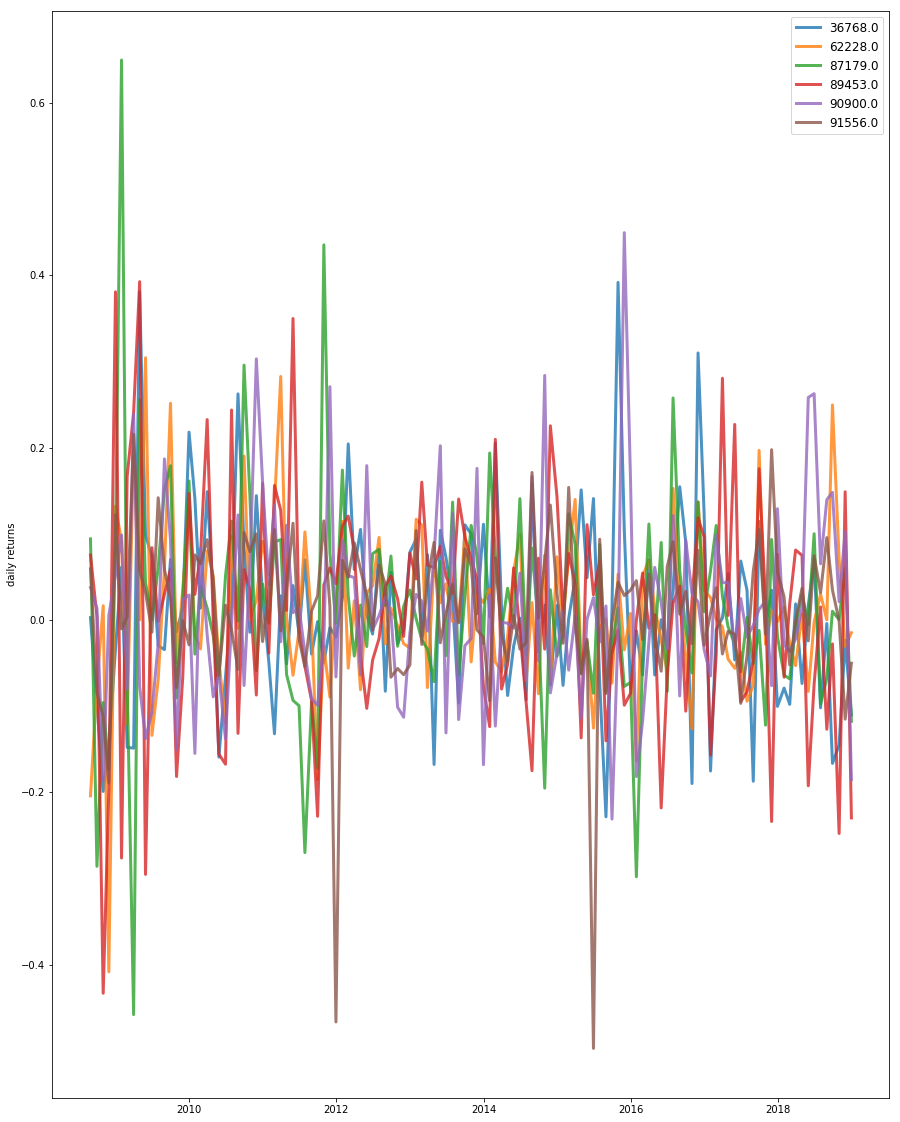

In [14]:
# Have a look at the returns of each stocks to see the volatility
# We can see that 2009 was the period with the most volatility.
returns_of_assets = datagoodorder.pct_change()
plt.figure(figsize=(15, 20))
for c in returns_of_assets.columns.values:
    plt.plot(returns_of_assets.index, returns_of_assets[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper right', fontsize=12)
plt.ylabel('daily returns')

In [15]:
df = pd.DataFrame(returns_of_assets)
len(df.columns)

6

In [25]:
#Creat two function: one to calculate the portfolio annualized return and standard deviation
# and one to compute portfolios with random weights
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights )*12
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(12)
    return std, returns 

def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3,num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(6)
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record

In [26]:
#Assigne returns, mean and covariances
returns = datagoodorder.pct_change()
mean_returns = returns.mean()
cov_matrix = returns.cov()

#Define the number of portfolio we want to compute
num_portfolios = 10000
risk_free_rate = lastrfrate

In [27]:
# Define a function to calculate the max sharpe ratio, min volatility portfolios
# and plot them with the other portfolio computes in a plot
def display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, weights = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate) 
    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index=datagoodorder.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
   
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=datagoodorder.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
   
    print ("-"*80)
    print ("Maximum Sharpe Ratio Portfolio Allocation\n")
    print ("Annualised Return:", round(rp,2))
    print ("Annualised Volatility:", round(sdp,2))
    print ("\n")
    print (max_sharpe_allocation)
    print ("-"*80)
    print ("Minimum Volatility Portfolio Allocation\n")
    print ("Annualised Return:", round(rp_min,2))
    print ("Annualised Volatility:", round(sdp_min,2))
    print ("\n")
    print (min_vol_allocation)
   

    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='viridis_r', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='+',color='g',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='+',color='b',s=500, label='Minimum volatility')
    plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.15
Annualised Volatility: 0.21


permno      36768.0  62228.0  87179.0  89453.0  90900.0  91556.0
allocation    16.03     6.38     11.5     6.23    29.66     30.2
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.14
Annualised Volatility: 0.2


permno      36768.0  62228.0  87179.0  89453.0  90900.0  91556.0
allocation    20.75    18.69     7.52     8.55    21.51    22.98


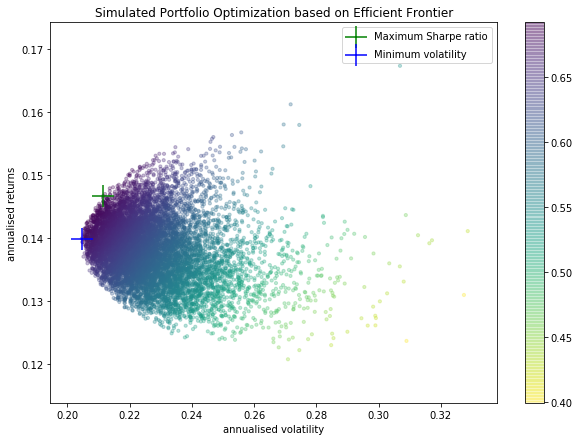

In [28]:
display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)

In [29]:
# Initiate the constrains that the maximum sum of our portfolio should be equal to 1
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x)-1})

In [30]:
# Instead of trying to maximise a positive sharpe ratio, we will minimize a negative sharpe ratio which conclude to the same results but is easier to implement.
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_var, p_ret = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_var

def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(neg_sharpe_ratio, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

In [31]:
# Define functions to have the minimum variance and the portfolios vollailities
def portfolio_volatility(weights, mean_returns, cov_matrix):
    return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[0]

def min_variance(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args,

                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

In [32]:
# Define a function to determine the portfolio that will compose the efficient frontier
def efficient_return(mean_returns, cov_matrix, target):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    def portfolio_return(weights):
        return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[1]
    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0,1) for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result
def efficient_frontier(mean_returns, cov_matrix, returns_range):
    efficients = []
    for ret in returns_range:
        efficients.append(efficient_return(mean_returns, cov_matrix, ret))
    return efficients

In [33]:
# Define a function that will display the portfolio with the minimized negative sharpe ratio
#, the minimum volatility and the portfolio that will compose the efficient frontier.
def display_ef_with_selected(mean_returns, cov_matrix, risk_free_rate):
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=datagoodorder.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    max_sharpe_allocation

    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=datagoodorder.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    an_vol = np.std(returns) * np.sqrt(12)
    an_rt = mean_returns * 12
    
    print ("-"*80)
    print ("Maximum Sharpe Ratio Portfolio Allocation\n")
    print ("Annualised Return:", round(rp,2))
    print ("Annualised Volatility:", round(sdp,2))
    print ("\n")
    print (max_sharpe_allocation)
    print ("-"*80)
    print ("Minimum Volatility Portfolio Allocation\n")
    print ("Annualised Return:", round(rp_min,2))
    print ("Annualised Volatility:", round(sdp_min,2))
    print ("\n")
    print (min_vol_allocation)
    print ("-"*80)
    print ("Individual Stock Returns and Volatility\n")
   
    
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.scatter(an_vol,an_rt,marker='*',s=200, color='r')

    ax.scatter(sdp,rp,marker='+',color='g',s=500, label='Optimal Risky Portfolio')
    ax.scatter(sdp_min,rp_min,marker='+',color='b',s=500, label='Minimum Variance Portfolio')

    target = np.linspace(rp_min, 0.475, 50)
 
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    ax.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-', color='black', label='efficient frontier')
    ax.plot([0,sdp],[risk_free_rate,rp], linestyle='--', color='cyan', label='Capital Allocation Line')
    ax.set_title('Portfolio Optimization with Individual Stocks')
    ax.set_xlabel('annualised volatility')
    ax.set_ylabel('annualised returns')
    ax.legend(labelspacing=0.8)
    
    return(np.transpose(max_sharpe_allocation))
   

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.15
Annualised Volatility: 0.21


permno      36768.0  62228.0  87179.0  89453.0  90900.0  91556.0
allocation    18.63    10.03    10.82     6.33    28.32    25.86
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.14
Annualised Volatility: 0.2


permno      36768.0  62228.0  87179.0  89453.0  90900.0  91556.0
allocation     19.4    18.48     7.96     8.38    19.81    25.97
--------------------------------------------------------------------------------
Individual Stock Returns and Volatility



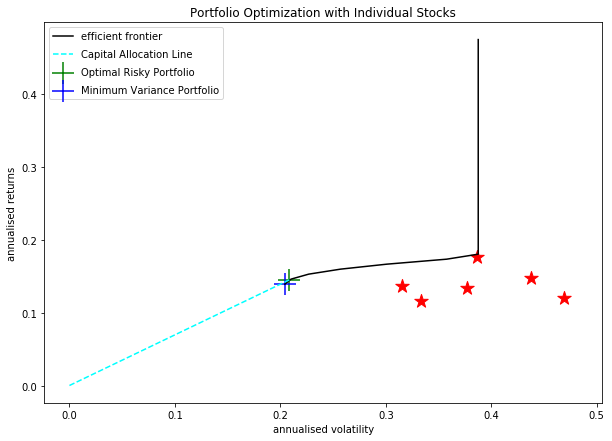

In [34]:
#Display the function above
max_sharpe_allocation=display_ef_with_selected(mean_returns, cov_matrix, risk_free_rate)


In [35]:
# Show the weight of the max sharpe ratio allocation
max_sharpe_allocation


,allocation
permno,
36768.0,18.63
62228.0,10.03
87179.0,10.82
89453.0,6.33
90900.0,28.32
91556.0,25.86


In [36]:
max_sharpe_allocation = pd.DataFrame(max_sharpe_allocation)
max_sharpe_allocation.loc[max_sharpe_allocation['allocation'].idxmax()]
#max sharpe ratio weight is 42.21% for UNITEDHEALTH GROUP INC (92655)

allocation    28.32
Name: 90900.0, dtype: float64

In [37]:
#min_vol_allocation = pd.DataFrame(min_vol_allocation)
#min_vol_allocation.loc[min_vol_allocation['allocation'].idxmax()]
#min volatility ratio gives 17.22% weight to PEPSICO INC (13856)


# B) and C)

In [38]:
# Import packages needed 
import statsmodels.formula.api as sm

In [39]:
# Compute the market return based on fama french risk free rate and excess return of the market
marketrate = datareg1['rf'] + datareg1['mktrf']

In [40]:
#Select two stocks
dataforpepsico= returns.iloc[:,4]#PEPSICO INC (13856)
dataforunitedhealth = returns.iloc[:,3] # UNITEDHEALTH GROUP INC (92655)


In [ ]:
dataforpepsico.reset_index(drop=True,inplace=True)
dataforunitedhealth.reset_index(drop=True,inplace=True)

In [ ]:
dataforpepsico = pd.DataFrame(dataforpepsico)
dataforpepsico.columns =['Pepsi_co']
dataforunitedhealth = pd.DataFrame(dataforunitedhealth)
dataforunitedhealth.columns = ['United_health_gp']

In [ ]:
#calculate excess return
dataforpepsicoExRet = dataforpepsico['Pepsi_co']- datareg1['rf']
dataforunitedhealthExRet = dataforunitedhealth['United_health_gp'] - datareg1['rf']


In [ ]:
#switch back to numeric index
dataforpepsicoExRet.reset_index(drop=True,inplace=True) #taking out date as there is a one day decallage between market and stock 
dataforunitedhealthExRet.reset_index(drop=True,inplace=True)
marketrate.reset_index(drop=True,inplace=True)



In [ ]:
#First regression
pepsicomarket = pd.DataFrame({'Pepsico':dataforpepsicoExRet,'Market_Return':marketrate})
resultpepsico = sm.ols(formula = 'Pepsico ~ Market_Return',data = pepsicomarket).fit()
print(resultpepsico.params)

In [ ]:
print(resultpepsico.summary())

In [ ]:
#Second regression
Unitedhealthmarket = pd.DataFrame({'United_health_gp':dataforunitedhealthExRet,'Market_Return':marketrate})
resultunitedhealth =sm.ols(formula = 'United_health_gp ~ Market_Return', data =Unitedhealthmarket).fit()
print(resultunitedhealth.params)

In [ ]:
print(resultunitedhealth.summary())

In [ ]:
# For both of our stocks, the intercept and the market variables are boths insignificatif at the 99% confidence interval.
# Therefore, CAPM is rejected for thoose stocks. 

### Question 2

# A)

In [ ]:
# pre-define the sample periods
COMPUSTAT_BEG_DATE = '2006-01-01'
COMPUTSTAT_END_DATE = '2019-01-01'
CRSP_BEG_DATE = '2006-01-01'
CRSP_END_DATE = '2019-01-01'


In [ ]:
# Postgres Query
statement1ff = """
          SELECT gvkey,cusip, revt,cogs,xsga,xint, datadate, at, pstkl, txditc, pstkrv, seq, pstk
          FROM comp.funda
          WHERE indfmt='INDL' 
          AND datafmt='STD'
          AND popsrc='D'
          AND consol='C'
          AND datadate BETWEEN '{}' AND '{}'
       """.format(COMPUSTAT_BEG_DATE,COMPUTSTAT_END_DATE)
comp = conn.raw_sql(statement1ff)
comp.tail()

In [ ]:
# set date and time to the standard format recognised by Pandas and other packages
comp['datadate']=pd.to_datetime(comp['datadate'])

# create a new variable for year
comp['year']=comp['datadate'].dt.year
# create a new variable for operating profit (revenue - Cost of Goods Sold - SG&A - interest expense)
comp['operatingprofit']=comp.iloc[:,2] - comp.iloc[:,3] - comp.iloc[:,4] - comp.iloc[:,5]

In [ ]:
# check data
comp.info()
comp.tail()

In [ ]:
###Preferred stock 
# if pstkrv is missing, then use pstkl ==>
comp['ps'] = np.where(comp['pstkrv'].isnull(), comp['pstkl'], comp['pstkrv'])

# if created ps is missing, then use pstk ==>
comp['ps'] = np.where(comp['ps'].isnull(),comp['pstk'], comp['ps'])

# if ps is still missing, then assign 0
comp['ps'] = np.where(comp['ps'].isnull(),0,comp['ps'])

In [ ]:
# again check prefered stock we just created
comp['ps'].describe()

In [ ]:
# assign 0 to txditc ==>
comp['txditc'] = comp['txditc'].fillna(0)

# create a variable, be, for book value of equity 
# BE = stockholders' equity + deferred taxes + investment tax credit - Preferred Sto
comp['be'] = comp['seq'] + comp['txditc'] - comp['ps']

# if be is negative, replaced by NaN 
comp['be'] = np.where(comp['be'] > 0, comp['be'], np.nan)

In [ ]:
# check book value of equity
comp['be'].describe()
comp.head()

In [ ]:
# sort values so that the dataframe is constructed by id and time
comp = comp.sort_values(by=['gvkey','datadate']) # gvkey is the primary company id

# count obs starting from 0 to length of the group -1
comp['count'] = comp.groupby(['gvkey']).cumcount()

# house cleanning
comp = comp[['gvkey','datadate','year','be','count','at','operatingprofit']]

In [ ]:
# create the profitability factor
comp['OpProfitonEquity']=comp.iloc[:,6] / comp.iloc[:,3]

In [ ]:
comp.info()
comp.head(20)

In [ ]:
# sql for returning a merged crsp price dataset
# its a large dataset, takes time to run
statementff2 = """
          SELECT a.permno, a.permco, a.date, a.ret, a.retx, a.shrout, a.prc,
                 b.shrcd, b.exchcd
          FROM crsp.msf AS a
          LEFT JOIN crsp.msenames AS b
          ON a.permno=b.permno
          AND b.namedt<=a.date
          AND a.date<=b.nameendt
          WHERE a.permno in %(permnos)s 
          AND a.date BETWEEN '{}' AND '{}'
          AND b.exchcd BETWEEN 1 AND 3
       """.format(CRSP_BEG_DATE, CRSP_END_DATE)
crsp_m = conn.raw_sql(statementff2, params=perm)

In [ ]:
# check data
crsp_m.info()
crsp_m.head()

In [ ]:
# change variable format to int
crsp_m[['permco','permno','shrcd','exchcd']] = crsp_m[['permco','permno','shrcd','exchcd']].astype(int)

In [ ]:
# format datatime
crsp_m['date'] = pd.to_datetime(crsp_m['date'])

crsp_m['jdate'] = crsp_m['date'] + MonthEnd(0) 

In [ ]:
###Add delisting return
dlret = conn.raw_sql("SELECT permno, dlret, dlstdt FROM crsp.msedelist")

# work on datetime
dlret['dlstdt'] = pd.to_datetime(dlret['dlstdt'])
dlret['jdate'] = dlret['dlstdt'] + MonthEnd(0)

In [ ]:
# merge two datasets
crsp = pd.merge(crsp_m, dlret, how='left',on=['permno','jdate'])

In [ ]:
# house cleaning
crsp['dlret'] = crsp['dlret'].fillna(0)
crsp['ret'] = crsp['ret'].fillna(0)
crsp['retadj'] = (1 + crsp['ret']) * (1 + crsp['dlret']) - 1
crsp['me'] = crsp['prc'].abs() * crsp['shrout'] # calculate market equity
crsp = crsp.drop(['dlret','dlstdt','prc','shrout'], axis = 1)
crsp = crsp.sort_values(by = ['jdate','permco','me'])

In [ ]:
crsp.info()
crsp.head()

In [ ]:
###Aggregate market cap to company level
# sum of me across different permno belonging to same permco a given date
crsp_summe = crsp.groupby(['jdate','permco'])['me'].sum().reset_index()
# permno with largest mktcap in a permco/date
crsp_maxme = crsp.groupby(['jdate','permco'])['me'].max().reset_index()

# join by jdate/maxme to find the permno
crsp1 = pd.merge(crsp, crsp_maxme, how = 'inner', on = ['jdate','permco','me'])
# drop me column and replace with the sum me
crsp1 = crsp1.drop(['me'], axis = 1)
# join with sum of me to get the correct market cap info
crsp2 = pd.merge(crsp1, crsp_summe, how = 'inner', on = ['jdate','permco'])
# sort by permno and date and also drop duplicates
crsp2 = crsp2.sort_values(by = ['permno','jdate']).drop_duplicates()

In [ ]:
# inspect databases
crsp2.info()
crsp2.head()

### Work on FF datetime

In [ ]:
# create year and month
crsp2['year'] = crsp2['jdate'].dt.year
crsp2['month'] = crsp2['jdate'].dt.month
# keep December market cap
decme = crsp2[crsp2['month'] == 12]
# house keeping
decme = decme[['permno','date','jdate','me','year']].rename(columns={'me':'dec_me'})

In [ ]:
decme.info()
decme.head()

In [ ]:
### July to June dates
crsp2['ffdate'] = crsp2['jdate'] + MonthEnd(-6)
crsp2['ffyear'] = crsp2['ffdate'].dt.year
crsp2['ffmonth'] = crsp2['ffdate'].dt.month
crsp2['1+retx'] = 1 + crsp2['retx']
crsp2 = crsp2.sort_values(by = ['permno','date'])

In [ ]:
# inspect
crsp2.info()
crsp2.head()

In [ ]:
##Stock level characteristics
# cumret by stock
crsp2['cumretx'] = crsp2.groupby(['permno','ffyear'])['1+retx'].cumprod()
# lag cumret
# sSort data first to have good dates?
crsp2['lcumretx'] = crsp2.groupby(['permno'])['cumretx'].shift(1) 

In [ ]:
# inspect
crsp2.info()
crsp2.head()

In [ ]:
## Dealing with lag market cap
# lag market cap
crsp2['lme'] = crsp2.groupby(['permno'])['me'].shift(1)

# if first permno then use me/(1+retx) to replace the missing value
crsp2['count'] = crsp2.groupby(['permno']).cumcount()
crsp2['lme'] = np.where(crsp2['count'] == 0, crsp2['me']/crsp2['1+retx'], crsp2['lme'])

In [ ]:
# baseline me (june market cap?)
mebase = crsp2[crsp2['ffmonth'] == 1][['permno','ffyear', 'lme']].rename(columns={'lme':'mebase'})

In [ ]:
mebase.info()
mebase.head()

In [ ]:
# merge result back together
crsp3 = pd.merge(crsp2, mebase, how='left', on=['permno','ffyear'])

In [ ]:
crsp3.info()
crsp3.head()

In [ ]:
# create a new variable from lag market cap (for weight later on)
crsp3['wt']=np.where(crsp3['ffmonth']==1, crsp3['lme'], crsp3['mebase']*crsp3['lcumretx'])

decme['year'] = decme['year'] + 1
decme = decme[['permno','year','dec_me']]

# Info as of June so that we have data in one place (row) to construct our portfolios
crsp3_jun = crsp3[crsp3['month'] == 6]

crsp_jun = pd.merge(crsp3_jun, decme, how='inner', on=['permno','year'])

In [ ]:
# make our crsp table presentable
crsp_jun = crsp_jun[['permno','date', 'jdate', 'shrcd','exchcd','retadj','me','wt','cumretx','mebase','lme','dec_me']]
crsp_jun = crsp_jun.sort_values(by=['permno','jdate']).drop_duplicates()
crsp_jun.head()


### Retrieving CCm data

In [ ]:
ccm=conn.raw_sql("""
                    SELECT gvkey, lpermno AS permno, linktype, linkprim, 
                    linkdt, linkenddt
                    FROM crsp.ccmxpf_linktable
                    WHERE SUBSTR(linktype,1,1)='L'
                    AND (linkprim ='C' OR linkprim='P')
                 """)
ccm.head()

In [ ]:
# convert datetime
ccm['linkdt']=pd.to_datetime(ccm['linkdt'])
ccm['linkenddt']=pd.to_datetime(ccm['linkenddt'])
# if linkenddt is missing then set to today date
ccm['linkenddt']=ccm['linkenddt'].fillna(pd.to_datetime('today'))

In [ ]:
####Merge with compustat and crsp
# left merge on gvkey
ccm1 = pd.merge(comp[['gvkey', 'datadate', 'be', 'count','at','OpProfitonEquity']], ccm, how = 'left', on = ['gvkey'])
ccm1['yearend'] = ccm1['datadate'] + YearEnd(0)
# create 'jdate' for further merge with crsp dataset
ccm1['jdate'] = ccm1['yearend'] + MonthEnd(6)

In [ ]:
# set link date bounds
ccm2 = ccm1[(ccm1['jdate'] >= ccm1['linkdt']) & (ccm1['jdate'] <= ccm1['linkenddt'])]
ccm2 = ccm2[['gvkey', 'permno', 'datadate', 'yearend', 'jdate', 'be', 'count','at','OpProfitonEquity']]

In [ ]:
# link comp and crsp
ccm_jun=pd.merge(crsp_jun, ccm2, how='inner', on=['permno', 'jdate'])

# Calculate book to market ratio
ccm_jun['beme']=ccm_jun['be']*1000/ccm_jun['dec_me']
# Calculate asset growth. Shift the cells by one. Important to note that the asset growth will be computed 50times on wrong data namely between two companies but as the first year is not taking into account in the following code later it is fine.
ccm_jun['at+1']=ccm_jun['at'].shift(1)
ccm_jun['Asset_growth']=(ccm_jun['at']/ccm_jun['at+1'])-1
ccm_jun.head()

In [ ]:
ccm_jun.info()
ccm_jun.head()

In [ ]:
#https://wrds-www.wharton.upenn.edu/pages/support/applications/portfolio-construction-and-market-anomalies/characteristic-based-benchmarks-daniel-grinblatt-titman-and-wermers-1997-python-version/
# Create (12,1) Momentum Factor with at least one year of returns
_tmp_crsp = ccm_jun[['permno','jdate','retadj', 'me', 'exchcd']].sort_values(['permno','jdate']).set_index('jdate')
#replace missing return with 0
_tmp_crsp['retadj']=_tmp_crsp['retadj'].fillna(0)
_tmp_crsp['logret']=np.log(1+_tmp_crsp['retadj'])
_tmp_cumret = _tmp_crsp.groupby(['permno'])['logret'].rolling(12, min_periods=0).sum()
_tmp_cumret = _tmp_cumret.reset_index()
_tmp_cumret['cumret']=np.exp(_tmp_cumret['logret'])-1

sizemom = pd.merge(_tmp_crsp.reset_index(), _tmp_cumret[['permno','jdate','cumret']], how='left', on=['permno','jdate'])
sizemom['mom']=sizemom.groupby('permno')['cumret'].shift(1)

sizemom=sizemom[sizemom['jdate'].dt.month==6].drop(['logret','cumret'], axis=1)
sizemom.head()

In [ ]:
#Insert our momentum
ccm_jun['mom']=sizemom['mom']
ccm_jun

In [ ]:
# select NYSE stocks for bucket breakdown
# exchcd = 1 and positive beme and positive me and shrcd in (10,11) and at least 2 years in comp
nyse_cond = (ccm_jun['exchcd'] == 1) & (ccm_jun['beme'] > 0) & (ccm_jun['me'] > 0) & (ccm_jun['count'] >= 1) & ((ccm_jun['shrcd'] == 10) | (ccm_jun['shrcd'] == 11))
# NOTE: & --> AND; | --> OR
                
nyse=ccm_jun[nyse_cond]

# Momentum breakdown
sizemom=sizemom.sort_values(['jdate','permno']).drop_duplicates()
nysem = sizemom[sizemom['exchcd']==1]
nyse_mom = nysem.groupby(['jdate'])['mom'].describe(percentiles=[0.3,0.7,]).reset_index()
nyse_mom = nyse_mom[['jdate','30%','70%']].rename(columns={'30%':'MoM30', '70%':'MoM70'})


#Investment breakdown
nyse_invest = nyse.groupby(['jdate'])['Asset_growth'].describe(percentiles=[0.3,0.7]).reset_index()
nyse_invest=nyse_invest[['jdate','30%','70%']].rename(columns={'30%':'invest30', '70%':'invest70'})

# size breakdown
nyse_sz=nyse.groupby(['jdate'])['me'].median().to_frame().reset_index().rename(columns={'me':'sizemedn'})

#Profitability breakdown
nyse_profit=nyse.groupby(['jdate'])['OpProfitonEquity'].describe(percentiles=[0.3, 0.7]).reset_index()
nyse_profit=nyse_profit[['jdate','30%','70%']].rename(columns={'30%':'profit30', '70%':'profit70'})


# beme breakdown
nyse_bm=nyse.groupby(['jdate'])['beme'].describe(percentiles=[0.3, 0.7]).reset_index()
nyse_bm=nyse_bm[['jdate','30%','70%']].rename(columns={'30%':'bm30', '70%':'bm70'})

# merge two bucket breakdown datasets
nyse_breaks3 = pd.merge(nyse_invest,nyse_sz, how='inner', on=['jdate'])
nyse_breaks2 = pd.merge(nyse_breaks3, nyse_bm, how='inner', on=['jdate'])
nyse_breaks1 = pd.merge(nyse_breaks2,nyse_profit, how='inner', on=['jdate'])
nyse_breaks = pd.merge(nyse_breaks1,nyse_mom, how='inner', on=['jdate'])

# merge back to our main dataset
ccm1_jun = pd.merge(ccm_jun, nyse_breaks, how='left', on=['jdate'])


In [ ]:
nyse

In [ ]:
nyse_invest.head()

In [ ]:
np.transpose(ccm1_jun)


### Function for assigning characteristics bucket

In [ ]:
# functions
def momentum_bucket(row):
    if row['mom']<=row['MoM30']:
        value = 'Lm'
    elif row['mom']<=row['MoM70']:
        value='M'
    elif row['mom']>row['MoM70']:
        value='Hm'
    else:
        value=''
    return value

def profit_bucket(row):
    if row['OpProfitonEquity']<=row['profit30']:
        value = 'W'
    elif row['OpProfitonEquity']<=row['profit70']:
        value='M'
    elif row['OpProfitonEquity']>row['profit70']:
        value='R'
    else:
        value=''
    return value

def sz_bucket(row):
    if row['me']==np.nan:
        value=''
    elif row['me']<=row['sizemedn']:
        value='S'
    else:
        value='B'
    return value

def invest_bucket(row):
    if row['Asset_growth']<=row['invest30']:
        value = 'C'
    elif row['Asset_growth']<=row['invest70']:
        value='M'
    elif row['Asset_growth']>row['invest70']:
        value='A'
    else:
        value=''
    return value

def bm_bucket(row):
    if 0<=row['beme']<=row['bm30']:
        value = 'L'
    elif row['beme']<=row['bm70']:
        value='M'
    elif row['beme']>row['bm70']:
        value='H'
    else:
        value=''
    return value


In [ ]:
##Assign momentum portfolio
ccm1_jun['momentumport'] = np.where((ccm1_jun['beme']>0) & 
                            (ccm1_jun['me']>0) & 
                            (ccm1_jun['count']>=1) ,
                            ccm1_jun.apply(momentum_bucket, axis=1), '')

#assign protiftability portfolio
ccm1_jun['profitport'] = np.where((ccm1_jun['beme']>0) & 
                            (ccm1_jun['me']>0) & 
                            (ccm1_jun['count']>=1) ,
                            ccm1_jun.apply(profit_bucket, axis=1), '')

# assign size portfolio
ccm1_jun['szport'] = np.where((ccm1_jun['beme']>0) & 
                            (ccm1_jun['me']>0) & 
                            (ccm1_jun['count']>=1), 
                            ccm1_jun.apply(sz_bucket, axis=1), '')
# assign investment portfolios
ccm1_jun['investport'] = np.where((ccm1_jun['beme']>0) & 
                            (ccm1_jun['me']>0) & 
                            (ccm1_jun['count']>=1), 
                            ccm1_jun.apply(invest_bucket, axis=1), '')

# assign book-to-market portfolio
ccm1_jun['bmport'] = np.where((ccm1_jun['beme']>0) & 
                            (ccm1_jun['me']>0) & 
                            (ccm1_jun['count']>=1), 
                            ccm1_jun.apply(bm_bucket, axis=1), '')

# create positivebmeme and nonmissport variable
ccm1_jun['posbm'] = np.where((ccm1_jun['beme']>0) & 
                           (ccm1_jun['me']>0) & 
                           (ccm1_jun['count']>=1), 
                           1, 0)
ccm1_jun['nonmissport']=np.where((ccm1_jun['bmport']!=''), 1, 0)

# store portfolio assignment as of June
june = ccm1_jun[['permno','date', 'jdate','momentumport','profitport','bmport','investport','szport','at','posbm','OpProfitonEquity','nonmissport']]
june['ffyear'] = june['jdate'].dt.year
june.head()

In [ ]:
####Merge with monthly returns
# merge back with monthly records
crsp3 = crsp3[['date','permno','shrcd','exchcd','retadj',
               'me','wt','cumretx','ffyear','jdate']]
ccm3=pd.merge(crsp3, 
              june[['permno','ffyear','momentumport','profitport','bmport','investport','szport','at','posbm','OpProfitonEquity','nonmissport']], 
              how='left', 
              on=['permno','ffyear'])

In [ ]:
# keeping only records that meet the criteria
ccm4=ccm3[(ccm3['wt']>0) & 
          (ccm3['posbm']==1) &
          (ccm3['nonmissport']==1) & 
          ((ccm3['shrcd']==10) | (ccm3['shrcd']==11))]

In [ ]:
###Value weighted returns
# function to calculate value weighted return
def wavg(group, avg_name, weight_name):
    d = group[avg_name]
    w = group[weight_name]
    try:
        return (d * w).sum() / w.sum()
    except ZeroDivisionError: # in case of zero division
        return np.nan

In [ ]:
#### value-weigthed return
# weighted-average function suggested by Wes McKinney
# We decide to make pairs of size and each of the factors, as proposed by Fama French in their five factor asset pricing model paper. 


In [ ]:
# Pairs of size and momentum
vwret = ccm4.groupby(['jdate','szport','momentumport']).apply(wavg, 'retadj', 'wt').to_frame().reset_index().rename(columns={0: 'vwret'})
vwret['smport'] = vwret['szport'] + vwret['momentumport'] # <= concat string

# firm count
vwret_n = ccm4.groupby(['jdate','szport','momentumport'])['retadj'].count().reset_index().rename(columns={'retadj':'n_firms'})
vwret_n['smport'] = vwret_n['szport'] + vwret_n['momentumport']

# preliminary results
# really is transposing the data: use date as index, columns is sbport, values is weighted average
ff_factors = vwret.pivot(index='jdate', columns='smport', values='vwret').reset_index()
ff_nfirms = vwret_n.pivot(index='jdate', columns='smport', values='n_firms').reset_index()

In [ ]:
ff_factors.head()

In [ ]:

# weighted-average function suggested by Wes McKinney
# We decide to make pairs of size and each of the factors, as proposed by Fama French in their five factor asset pricing model paper. 
#Then size and BM
vwret0 = ccm4.groupby(['jdate','szport','bmport']).apply(wavg, 'retadj', 'wt').to_frame().reset_index().rename(columns={0: 'vwret'})
vwret0['sbport'] = vwret0['szport'] + vwret0['bmport'] # <= concat string

# firm count
vwret_n0 = ccm4.groupby(['jdate','szport','bmport'])['retadj'].count().reset_index().rename(columns={'retadj':'n_firms'})
vwret_n0['sbport'] = vwret_n0['szport'] + vwret_n0['bmport']

# preliminary results
# really is transposing the data: use date as index, columns is sbport, values is weighted average
ff_factors0 = vwret0.pivot(index='jdate', columns='sbport', values='vwret').reset_index()
ff_nfirms0 = vwret_n0.pivot(index='jdate', columns='sbport', values='n_firms').reset_index()

In [ ]:
ff_factors0.head()

In [ ]:
#Then size and profitability
vwret01 = ccm4.groupby(['jdate','szport','profitport']).apply(wavg, 'retadj', 'wt').to_frame().reset_index().rename(columns={0: 'vwret'})
vwret01['sPport'] = vwret01['szport'] + vwret01['profitport'] # <= concat string

# firm count
vwret_n01 = ccm4.groupby(['jdate','szport','profitport'])['retadj'].count().reset_index().rename(columns={'retadj':'n_firms'})
vwret_n01['sPport'] = vwret_n01['szport'] + vwret_n01['profitport']

# preliminary results
# really is transposing the data: use date as index, columns is sbport, values is weighted average
ff_factors01 = vwret01.pivot(index='jdate', columns='sPport', values='vwret').reset_index()
ff_nfirms01 = vwret_n01.pivot(index='jdate', columns='sPport', values='n_firms').reset_index()

In [ ]:
ff_factors01.head()

In [ ]:
#Then size and investment
vwret02 = ccm4.groupby(['jdate','szport','investport']).apply(wavg, 'retadj', 'wt').to_frame().reset_index().rename(columns={0: 'vwret'})
vwret02['sIport'] = vwret02['szport'] + vwret02['investport'] # <= concat string

# firm count
vwret_n02 = ccm4.groupby(['jdate','szport','investport'])['retadj'].count().reset_index().rename(columns={'retadj':'n_firms'})
vwret_n02['sIport'] = vwret_n02['szport'] + vwret_n02['investport']

# preliminary results
# really is transposing the data: use date as index, columns is sbport, values is weighted average
ff_factors02 = vwret02.pivot(index='jdate', columns='sIport', values='vwret').reset_index()
ff_nfirms02 = vwret_n02.pivot(index='jdate', columns='sIport', values='n_firms').reset_index()

In [ ]:
ff_factors02.head()


In [ ]:
ff_factors.head()

### Creation of the facors

In [ ]:

# Create MOM factors
ff_factors['SmallHighRet']=(ff_factors['SHm']+ff_factors['BHm'])/2
ff_factors['SmallLowRet']=(ff_factors['SLm']+ff_factors['BLm'])/2
ff_factors['Momentum'] = ff_factors['SmallHighRet']-ff_factors['SmallLowRet']

# n firm count
ff_nfirms['SmallHighRet']=ff_nfirms['SHm']+ff_nfirms['BHm']
ff_nfirms['SmallLowRet']=ff_nfirms['SLm']+ff_nfirms['BLm']
ff_nfirms['Momentum']=ff_nfirms['SmallHighRet']+ff_nfirms['SmallLowRet']

ff_factors=ff_factors.rename(columns={'jdate':'date'})

# Create HML factors
ff_factors0['WH']=(ff_factors0['BH']+ff_factors0['SH'])/2
ff_factors0['WL']=(ff_factors0['BL']+ff_factors0['SL'])/2
ff_factors0['WHML'] = ff_factors0['WH']-ff_factors0['WL']

# n firm count
ff_nfirms0['H']=ff_nfirms0['SH']+ff_nfirms0['BH']
ff_nfirms0['L']=ff_nfirms0['SL']+ff_nfirms0['BL']
ff_nfirms0['HML']=ff_nfirms0['H']+ff_nfirms0['L']

# Creat SMB factor
ff_factors0['WB']=(ff_factors0['BL']+ff_factors0['BM']+ff_factors0['BH'])/3
ff_factors0['WS']=(ff_factors0['SL']+ff_factors0['SM']+ff_factors0['SH'])/3
ff_factors0['WSMB'] = ff_factors0['WS']-ff_factors0['WB']

ff_factors0=ff_factors0.rename(columns={'jdate':'date'})

# n firm count
ff_nfirms0['B']=ff_nfirms0['BL']+ff_nfirms0['BM']+ff_nfirms0['BH']
ff_nfirms0['S']=ff_nfirms0['SL']+ff_nfirms0['SM']+ff_nfirms0['SH']
ff_nfirms0['SMB']=ff_nfirms0['B']+ff_nfirms0['S']
ff_nfirms0['TOTAL']=ff_nfirms0['SMB']

ff_nfirms0=ff_nfirms0.rename(columns={'jdate':'date'})

# create RWA factor
ff_factors01['WeightRobust']=(ff_factors01['SR']+ff_factors01['BR'])*1/2 #half small robut + big robust
ff_factors01['WeightWeak']=(ff_factors01['SW']+ff_factors01['BW'])*1/2 #half small weak + big weak
ff_factors01['WRW'] = ff_factors01['WeightRobust']-ff_factors01['WeightWeak']

# n firm count
ff_nfirms01['Robust']=ff_nfirms01['SR']+ff_nfirms01['BR']
ff_nfirms01['Weak']=ff_nfirms01['SW']+ff_nfirms01['BW'] 
ff_nfirms01['RW']=ff_nfirms01['Robust']+ff_nfirms01['Weak']

ff_factors01=ff_factors01.rename(columns={'jdate':'date'})
ff_nfirms01=ff_nfirms01.rename(columns={'jdate':'date'})

#Creat CMA factor
ff_factors02['WeightConservative']=(ff_factors02['SC']+ff_factors02['BC'])*1/2 #half small conservative + big conservative
ff_factors02['WeightAgressive']=(ff_factors02['SA']+ff_factors02['SA'])*1/2 #half small aggressive + big aggressive
ff_factors02['WCA'] = ff_factors02['WeightConservative']-ff_factors02['WeightAgressive']

# n firm count
ff_nfirms02['Conservative']=ff_nfirms02['SC']+ff_nfirms02['BC']
ff_nfirms02['Aggressive']=ff_nfirms02['SA']+ff_nfirms02['BA']
ff_nfirms02['CA']=ff_nfirms02['Conservative']+ff_nfirms02['Aggressive']

ff_factors02=ff_factors02.rename(columns={'jdate':'date'})
ff_nfirms02=ff_nfirms02.rename(columns={'jdate':'date'})



In [ ]:
###Make one table with the whole

In [ ]:

table1 = pd.merge(ff_factors[['date','Momentum']], ff_factors0[['date','WSMB','WHML']], how='inner', on=['date'])
table2 = pd.merge(table1[['date','Momentum','WSMB','WHML']], ff_factors01[['date','WRW']], how='inner', on=['date'])
table3 = pd.merge(table2[['date','Momentum','WSMB','WHML','WRW']], ff_factors02[['date','WCA']], how='inner', on=['date'])
table3.tail()

In [ ]:
#Add market excess return and risk free rate from fama french database
famafrench = conn.raw_sql("SELECT date,mktrf,rf FROM ff.factors_monthly WHERE date between '2007-08-01' and '2018-12-31'")
famafrenchdata = pd.DataFrame(famafrench)
famafrenchdata.head()

In [ ]:
#Add market excess return and risk free rate from fama french database
famafrench = conn.raw_sql("SELECT date,mktrf,rf FROM ff.factors_monthly WHERE date between '2007-07-31' and '2018-12-31'")
famafrenchdata = pd.DataFrame(famafrench)
finaltable = pd.merge(table3[['date','Momentum','WSMB','WHML','WRW','WCA']], famafrenchdata[['mktrf','rf']], how='inner',left_index=True, right_index=True)
cleantable = pd.DataFrame(finaltable)
cleantable.head()

### Return of our portfolio calculation

In [ ]:
weightp = max_sharpe_allocation.T
weightp.head()


In [ ]:
#Extract the returns from the crsp dataset for our selected stocks 
datasetreturns=data.set_index('date')
datagoodreturnsorder=datasetreturns.pivot(columns='permno', values='ret')
datagoodreturnsorder.head()



In [ ]:
#Calculate the weighted return for each stock for each date
weightsarray = np.array(weightp)
retarray = np.array(datagoodreturnsorder)
weightedreturn = weightsarray/100 * retarray
df =pd.DataFrame(weightedreturn)
df.tail()

In [ ]:
#Sum all the returns from each stocks at each date to have the portfolio return
Portfolio = df.sum(axis=1)
PortfolioRet = pd.DataFrame(Portfolio)
PortfolioRet.columns = ['Ret']
PortfolioRet.head()

In [ ]:
#Merge with the other factors
FinalData=pd.merge(cleantable[['date','Momentum','WSMB','WHML','WRW','WCA','mktrf','rf']], PortfolioRet[['Ret']], how='inner',left_index=True, right_index=True)
FinalData.tail()

In [ ]:
#compute the excess return from our portfolio
FinalData['ExcessRetPort'] = FinalData['Ret'] - FinalData['rf']
FinalData.head()

# Test CAPM

In [ ]:
resultscapm = sm.ols(formula = 'ExcessRetPort ~ mktrf',data = FinalData).fit()
print(resultscapm.params)

In [ ]:
print(resultscapm.summary())
#as we can see CAPM is rejected as the t-value is inferior to any conventional significance level. 
#Furthermore, as the intercept has a t-value higher than 1.96 or 2.52, our portfolio has a positive alpha meaning that it beat the market>

# Test Fama French 3 factors

In [ ]:
resultsff3 = sm.ols(formula = 'ExcessRetPort ~ mktrf+WSMB+WHML ',data = FinalData).fit()
print(resultsff3.params)

In [ ]:
print(resultsff3.summary())
#Again, we have a positive alpha which is statistically significant and the market correlation isn't.
# SMB factor is highly significant meaning that we should invest in small stocks and short big market cap stocks. 
# HML is not statistically significant
#Rsquare increases by 18pts

# Test 6 factors

In [ ]:
resultsff6 = sm.ols(formula = 'ExcessRetPort ~ mktrf+WSMB+WHML+Momentum+WRW+WCA',data = FinalData).fit()
print(resultsff6.params)

In [ ]:
print(resultsff6.summary())
#The market, HML and CA are not statistically significant.
# SMB is significant and positive hence should buy small stocks and short big market stocks
#MOmentum is significant and negative, therefore we should short winners within our portfolio. 
#Robust portfolio is significant and negative, therefore we should short stocks that have high operating profitability within our portfolio. 

In [ ]:
### full 
# mastercard 10 only, kla tencor 13 2018 included, exelixis inc 6 (died after 2011?), brown & brown 1 only 2017 

# Part 3

In [ ]:
import csv
import datetime
import time
import pandas as pd
import numpy as np
import sqlite3
import requests
import os
import re
import requests
import pickle # nice module name, isn't it?
from bs4 import BeautifulSoup
from sqlalchemy import create_engine
from nltk.tokenize import RegexpTokenizer, sent_tokenize
from nltk.corpus import stopwords


In [ ]:
try:
   import selenium
except ImportError: 
    !pip install selenium

In [ ]:
from selenium import webdriver

In [ ]:
ourcompany    = ['3M CO',
                 'AMERISOURCEBERGEN CORP',
                 'APPLE INC',
                 'ARTESIAN RESOURCES CORP',
                 'BERKSHIRE HATHAWAY INC',
                 'BOSTON SCIENTIFIC CORP',
                 'BROWN FORMAN CORP',
                 'CALIFORNIA WATER SERVICE GROUP',
                 'CROSS TIMBERS ROYALTY TRUST',
                 'EATON VANCE CORP',
                 'EBAY INC',
                 'ESTEE LAUDER COMPANIES INC',
                 'EXXON MOBIL CORP',
                 'FLEXSTEEL INDUSTRIES INC',
                 'FREQUENCY ELECTRONICS INC',
                 'GENERAL ELECTRIC CO',
                 'GENOMIC HEALTH INC',
                 'GILEAD SCIENCES INC',
                 'GRACO INC',
                 'GRAINGER W W INC',
                 'HALLIBURTON CO',
                 'IMMERSION CORP',
                 'INTEL CORP',
                 'KRONOS WORLDWIDE INC',
                 'LILLY ELI & CO',
                 'MEDIFAST INC',
                 'MICROSOFT CORP',
                 'MOLINA HEALTHCARE INC',
                 'NATIONAL FUEL GAS CO',
                 'NEKTAR THERAPEUTICS',
                 'NETSCOUT SYSTEMS INC'
                 'NIKE INC']

In [ ]:
reserves =     ['NORTH EUROPEAN OIL ROYALTY TRUST',
                'NVIDIA CORP',
                'PARK ELECTROCHEMICAL CORP',
                'PEPSICO INC',
                'PERMIAN BASIN ROYALTY TRUST',
                'PSYCHEMEDICS CORP',
                'RANGE RESOURCES CORP',
                'RED ROBIN GOURMET BURGERS INC',
                'RITE AID CORP',
                'ROSS STORES INC',
                'SABINE ROYALTY TRUST',
                'SOUTHWESTERN ENERGY CO',
                'SYMANTEC CORP',
                'TREX CO INC',
                'Under Armour, Inc.',
                'UNITEDHEALTH GROUP INC',
                'VERIZON COMMUNICATIONS INC',
                'XILINX INC']

In [ ]:
ourcompanies = ourcompany + reserves
files = ['10-K']

In [ ]:
PERMNO = ['31051','36768','62228','75652','77729','82279','87179',
          '89453','90900','91556']

In [ ]:
## Function needed

In [ ]:
stopWordsFile = 'C:/Users/Alexander/Documents/Lancaster/Msc Finance/600 classes/ACF 602 Advanced Investment Management/Coursework/EDGAR-reports-Text-Analysis-master/StopWords_Generic.txt'
constraining_dictionaryFile  = 'C:/Users/Alexander/Documents/Lancaster/Msc Finance/600 classes/ACF 602 Advanced Investment Management/Coursework/EDGAR-reports-Text-Analysis-master/constraining_dictionary.txt'


In [ ]:
def url_to_text(url):
    resp = requests.get(url)
    soup = BeautifulSoup(resp.text, 'html.parser')
    for table in soup.find_all('table'):
        table.decompose()
    text = soup.get_text()
    return text
#Count total Words
    
def count_words(text):
    return len(str(text).split(" "))

# Count total characters
def count_chars(text):
    return len(str(text))

# Count numerics
def count_digit(text):
    return len([word for word in str(text).split(" ") if word.isdigit()]) # isdigit() is a string method

# Count stopwords
def count_stopwords(text, stop=stopwords.words('english')):
    num = len([word for word in str(text).split(' ') if word in stop])
    perc = num/len(str(text).split(" "))
    return num, perc

def clean_text_round2(text):
    # convert to lower case
    text = text.lower()
    text = re.sub(r'(\t|\v)', '', text)
    # remove \xa0 which is non-breaking space from ISO 8859-1, how to delete all remaining ISO 8859-1 symbols & chars?
    text = re.sub(r'\xa0', ' ', text)
    # remove newline feeds (\n) following hyphens
    text = re.sub(r'(-+)\n{2,}', r'\1', text)
    # remove hyphens preceded and followed by a blank space
    text = re.sub(r'\s-\s', '', text)
    # replace 'and/or' with 'and or'
    text = re.sub(r'and/or', r'and or', text)
    # tow or more hypens, periods, or equal signs, possiblly followed by spaces are removed
    text = re.sub(r'[-|\.|=]{2,}\s*', r'', text)
    # all underscores are removed
    text = re.sub(r'_', '', text)
    # 3 or more spaces are replaced by a single space
    text = re.sub(r'\s{3,}', ' ', text)
    # three or more line feeds, possibly separated by spaces are replaced by two line feeds
    text = re.sub(r'(\n\s*){3,}', '\n\n', text)
    # remove hyphens before a line feed
    text = re.sub(r'-+\n', '\n', text)
    # replace hyphens preceding a capitalized letter with a space
    text = re.sub(r'-+([A-Z].*)', r' \1', text)
    # remove capitalized or all capitals for March, May and August
    text = re.sub(r'(March|MARCH|May|MAY|August|AUGUST)', '', text)
    # remove punctuations
    #text = re.sub('[]'.format(re.escape(string.punctuation)), '', text)
    # remove line feeds
    text = re.sub('\n', ' ', text)
    # remove numbers?
    # replace single line feed \n with single space
    text = re.sub(r'\n', ' ', text)
    return text

# NOTE: 
## drop punctuation within numbers for number count
    text = re.sub('(?!=[0-9])(\.|,)(?=[0-9])', '', text)
    
#tokenizeing module and filtering tokens using stop words list, removing punctuations
# Tokenizer
def tokenizer(text):
    text = text.lower()
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(text)
    filtered_words = list(filter(lambda token: token not in stopWordList, tokens))
    return filtered_words

#Loading stop words dictionary for removing stop words
with open(stopWordsFile ,'r') as stop_words:
    stopWords = stop_words.read().lower()
stopWordList = stopWords.split('\n')
stopWordList[-1:] = []

def total_word_count(text):
    tokens = tokenizer(text)
    return len(tokens)

# calculating constraining score
with open(constraining_dictionaryFile ,'r') as constraining_dict:
    constrainDict=constraining_dict.read().lower()
constrainDictionary = constrainDict.split('\n')

def constraining_score(text):
    constrainWordnum =0
    rawToken = tokenizer(text)
    for word in rawToken:
        if word in constrainDictionary:
            constrainWordnum +=1
    sumConstrainScore = constrainWordnum 
    
    return sumConstrainScore

# Calculating constraining word proportion

def constraining_word_prop(constrainingScore,wordcount):
    constraining_word_proportion = 0
    if wordcount !=0:
        constraining_word_proportion = constrainingScore / wordcount
        
    return constraining_word_proportion

In [ ]:
#2008

In [ ]:
current_year = 2008 #datetime.date.today().year
current_quarter = 4 #(datetime.date.today().month - 1) // 3 + 1
start_year = 2008


years = list(range(start_year, current_year))
quarters = ['QTR1', 'QTR2', 'QTR3', 'QTR4']
history = [(y, q) for y in years for q in quarters]
#Look to look into the time frame wanted
for i in range(1, current_quarter + 1):
    history.append((current_year, 'QTR%d' % i))
urls = ['https://www.sec.gov/Archives/edgar/full-index/%d/%s/crawler.idx' % (x[0], x[1]) for x in history]
urls.sort()

#Pass via sqlite3 as is more efficient
con = sqlite3.connect('edgar_htm_idx.db')
cur = con.cursor()
cur.execute('DROP TABLE IF EXISTS idx')
cur.execute('CREATE TABLE idx (conm TEXT, type TEXT, cik TEXT, date TEXT, path TEXT)')
 
for url in urls:
    lines = requests.get(url).text.splitlines()
    cikloc = lines[7].find('CIK')
    nameloc = lines[7].find('Company Name')
    typeloc = lines[7].find('Form Type')
    dateloc = lines[7].find('Date Filed')
    urlloc = lines[7].find('URL')
    records = [tuple([line[:typeloc].strip(), line[typeloc:cikloc].strip(), line[cikloc:dateloc].strip(),
                      line[dateloc:urlloc].strip(), line[urlloc:].strip()]) for line in lines[9:]]
    cur.executemany('INSERT INTO idx VALUES (?, ?, ?, ?, ?)', records)
    print(url, 'downloaded and wrote to SQLite')
 
con.commit()
con.close()

engine2 = create_engine('sqlite:///edgar_htm_idx.db')
with engine2.connect() as conn, conn.begin():
    data30 = pd.read_sql_table('idx', conn)
    
dataourcomp1 = data30[data30['conm'].isin(ourcompanies)]
dataourcomp1 = dataourcomp1[dataourcomp1['type'].isin(files)]

#rearange
dataourcomp1 = dataourcomp1[['cik','conm','type','date','path']]

#save in csv
dataourcomp1.to_csv('edgar_htm_idx.csv')

#open the html 
with open('log09.csv', 'w', newline='') as log:
    logwriter = csv.writer(log)
 
    with open('edgar_htm_idx.csv', newline='') as infile:
        records = csv.reader(infile)
 
        for r in records:
            log_row = r.copy()
            print('Start fetching URL to', r[2], r[3], 'filed on', r[4], '...')
            start_time = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime())
 
            driver = webdriver.Chrome('./chromedriver')
 
            try:
                driver.get(r[5])
                #time.sleep(3 + random.random() * 3)
                filing_date = driver.find_element_by_xpath('//*[@id="formDiv"]/div[2]/div[1]/div[2]').text
                period_of_report = driver.find_element_by_xpath('//*[@id="formDiv"]/div[2]/div[2]/div[2]').text
                form_text = driver.find_element_by_xpath('//*[@id="formDiv"]/div/table/tbody/tr[2]/td[3]/a').text
                form_link = driver.find_element_by_link_text(form_text).get_attribute('href')
                end_time = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime())
                print('Success!', start_time, ' --> ', end_time, '\n')
                log_row = log_row + [start_time, end_time, filing_date, period_of_report, form_link]
 
            except:
                end_time = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime())
                print('Error!', start_time, ' --> ', end_time, '\n')
                log_row = log_row + [start_time, end_time, 'ERROR!']
 
            driver.quit()
 
            logwriter.writerow(log_row)
#read csv
FinalDataAnalysis1 = pd.read_csv('log09.csv')

#Paths 
FFdata1 = FinalDataAnalysis1.iloc[:,8]

# Actually obtain the text from requests via EDGAR, parsing using BS4 then text
texts1 = [url_to_text(url) for url in FFdata1]

# access index and value for a list
for idx, val in enumerate(ourcompanies):
    with open(val + ".pkl", "wb") as f:
        pickle.dump(texts1[idx], f)
        
# Load pickled files into a dictionary
# Key: company name
# value: parsed 10K text
datacleaned1 = {}

for _, val in enumerate(ourcompanies):
    with open(val + ".pkl", "rb") as f:
        datacleaned1[val] = pickle.load(f)

#Load dictionary
df001 = pd.DataFrame.from_dict(datacleaned1, orient='index', columns = ['text'])

# deal with reserved special html characters such as non-breaking space (`&nbsp`)
html_chars = {'&lt': 'lt', '&#60': 'lt', 
              '&gt': 'gt', '&#62': 'gt',
              '&nbsp': '', '&#160': '', 
              '&quot': '"', '&#34': '"', 
              '&apos': '\'', '&#39': '\'',
              '&amp': '&', '&#38': '&'}
df1 = pd.DataFrame(df001['text'].apply(clean_text_round2))

#counts the constraining words 
df1['constraining_score'] = df1.iloc[:,0].apply(constraining_score)
df1['word_count'] = df1.iloc[:,0].apply(total_word_count)
df1['constraining_word_proportion'] = np.vectorize(constraining_word_prop)(df1['constraining_score'],df1['word_count'])

#create our final table for the year
year1 =df1.drop('text', axis=1)
year1= year1.drop('constraining_score', axis=1)
year1= year1.drop('word_count', axis=1)
year1.index.name ='Company Name'
year1 = year1.rename(index=str, columns ={'constraining_word_proportion':'%cons'})
year1['permno'] =PERMNO
year1['date'] = '2008-06-30'
year1['ffyear'] = 2008

In [ ]:
#2009

In [ ]:
current_year = 2009 #datetime.date.today().year
current_quarter = 4 #(datetime.date.today().month - 1) // 3 + 1
start_year = 2009


years = list(range(start_year, current_year))
quarters = ['QTR1', 'QTR2', 'QTR3', 'QTR4']
history = [(y, q) for y in years for q in quarters]
#Look to look into the time frame wanted
for i in range(1, current_quarter + 1):
    history.append((current_year, 'QTR%d' % i))
urls = ['https://www.sec.gov/Archives/edgar/full-index/%d/%s/crawler.idx' % (x[0], x[1]) for x in history]
urls.sort()

#Pass via sqlite3 as is more efficient
con = sqlite3.connect('edgar_htm_idx.db')
cur = con.cursor()
cur.execute('DROP TABLE IF EXISTS idx')
cur.execute('CREATE TABLE idx (conm TEXT, type TEXT, cik TEXT, date TEXT, path TEXT)')
 
for url in urls:
    lines = requests.get(url).text.splitlines()
    cikloc = lines[7].find('CIK')
    nameloc = lines[7].find('Company Name')
    typeloc = lines[7].find('Form Type')
    dateloc = lines[7].find('Date Filed')
    urlloc = lines[7].find('URL')
    records = [tuple([line[:typeloc].strip(), line[typeloc:cikloc].strip(), line[cikloc:dateloc].strip(),
                      line[dateloc:urlloc].strip(), line[urlloc:].strip()]) for line in lines[9:]]
    cur.executemany('INSERT INTO idx VALUES (?, ?, ?, ?, ?)', records)
    print(url, 'downloaded and wrote to SQLite')
 
con.commit()
con.close()

engine2 = create_engine('sqlite:///edgar_htm_idx.db')
with engine2.connect() as conn, conn.begin():
    data30 = pd.read_sql_table('idx', conn)
    
dataourcomp1 = data30[data30['conm'].isin(ourcompanies)]
dataourcomp1 = dataourcomp1[dataourcomp1['type'].isin(files)]

#rearange
dataourcomp1 = dataourcomp1[['cik','conm','type','date','path']]

#save in csv
dataourcomp1.to_csv('edgar_htm_idx.csv')

#open the html 
with open('log09.csv', 'w', newline='') as log:
    logwriter = csv.writer(log)
 
    with open('edgar_htm_idx.csv', newline='') as infile:
        records = csv.reader(infile)
 
        for r in records:
            log_row = r.copy()
            print('Start fetching URL to', r[2], r[3], 'filed on', r[4], '...')
            start_time = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime())
 
            driver = webdriver.Chrome('./chromedriver')
 
            try:
                driver.get(r[5])
                #time.sleep(3 + random.random() * 3)
                filing_date = driver.find_element_by_xpath('//*[@id="formDiv"]/div[2]/div[1]/div[2]').text
                period_of_report = driver.find_element_by_xpath('//*[@id="formDiv"]/div[2]/div[2]/div[2]').text
                form_text = driver.find_element_by_xpath('//*[@id="formDiv"]/div/table/tbody/tr[2]/td[3]/a').text
                form_link = driver.find_element_by_link_text(form_text).get_attribute('href')
                end_time = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime())
                print('Success!', start_time, ' --> ', end_time, '\n')
                log_row = log_row + [start_time, end_time, filing_date, period_of_report, form_link]
 
            except:
                end_time = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime())
                print('Error!', start_time, ' --> ', end_time, '\n')
                log_row = log_row + [start_time, end_time, 'ERROR!']
 
            driver.quit()
 
            logwriter.writerow(log_row)
#read csv
FinalDataAnalysis1 = pd.read_csv('log09.csv')

#Paths 
FFdata1 = FinalDataAnalysis1.iloc[:,8]

# Actually obtain the text from requests via EDGAR, parsing using BS4 then text
texts1 = [url_to_text(url) for url in FFdata1]

# access index and value for a list
for idx, val in enumerate(ourcompanies):
    with open(val + ".pkl", "wb") as f:
        pickle.dump(texts1[idx], f)
        
# Load pickled files into a dictionary
# Key: company name
# value: parsed 10K text
datacleaned1 = {}

for _, val in enumerate(ourcompanies):
    with open(val + ".pkl", "rb") as f:
        datacleaned1[val] = pickle.load(f)

#Load dictionary
df001 = pd.DataFrame.from_dict(datacleaned1, orient='index', columns = ['text'])

# deal with reserved special html characters such as non-breaking space (`&nbsp`)
html_chars = {'&lt': 'lt', '&#60': 'lt', 
              '&gt': 'gt', '&#62': 'gt',
              '&nbsp': '', '&#160': '', 
              '&quot': '"', '&#34': '"', 
              '&apos': '\'', '&#39': '\'',
              '&amp': '&', '&#38': '&'}
df1 = pd.DataFrame(df001['text'].apply(clean_text_round2))

#counts the constraining words 
df1['constraining_score'] = df1.iloc[:,0].apply(constraining_score)
df1['word_count'] = df1.iloc[:,0].apply(total_word_count)
df1['constraining_word_proportion'] = np.vectorize(constraining_word_prop)(df1['constraining_score'],df1['word_count'])

#create our final table for the year
year2 =df1.drop('text', axis=1)
year2= year2.drop('constraining_score', axis=1)
year2= year2.drop('word_count', axis=1)
year2.index.name ='Company Name'
year2 = year2.rename(index=str, columns ={'constraining_word_proportion':'%cons'})
year2['permno'] =PERMNO
year2['date'] = '2009-06-30'
year2['ffyear'] = 2009

In [ ]:
#2010

In [ ]:
current_year = 2010 #datetime.date.today().year
current_quarter = 4 #(datetime.date.today().month - 1) // 3 + 1
start_year = 2010


years = list(range(start_year, current_year))
quarters = ['QTR1', 'QTR2', 'QTR3', 'QTR4']
history = [(y, q) for y in years for q in quarters]
#Look to look into the time frame wanted
for i in range(1, current_quarter + 1):
    history.append((current_year, 'QTR%d' % i))
urls = ['https://www.sec.gov/Archives/edgar/full-index/%d/%s/crawler.idx' % (x[0], x[1]) for x in history]
urls.sort()

#Pass via sqlite3 as is more efficient
con = sqlite3.connect('edgar_htm_idx.db')
cur = con.cursor()
cur.execute('DROP TABLE IF EXISTS idx')
cur.execute('CREATE TABLE idx (conm TEXT, type TEXT, cik TEXT, date TEXT, path TEXT)')
 
for url in urls:
    lines = requests.get(url).text.splitlines()
    cikloc = lines[7].find('CIK')
    nameloc = lines[7].find('Company Name')
    typeloc = lines[7].find('Form Type')
    dateloc = lines[7].find('Date Filed')
    urlloc = lines[7].find('URL')
    records = [tuple([line[:typeloc].strip(), line[typeloc:cikloc].strip(), line[cikloc:dateloc].strip(),
                      line[dateloc:urlloc].strip(), line[urlloc:].strip()]) for line in lines[9:]]
    cur.executemany('INSERT INTO idx VALUES (?, ?, ?, ?, ?)', records)
    print(url, 'downloaded and wrote to SQLite')
 
con.commit()
con.close()

engine2 = create_engine('sqlite:///edgar_htm_idx.db')
with engine2.connect() as conn, conn.begin():
    data30 = pd.read_sql_table('idx', conn)
    
dataourcomp1 = data30[data30['conm'].isin(ourcompanies)]
dataourcomp1 = dataourcomp1[dataourcomp1['type'].isin(files)]

#rearange
dataourcomp1 = dataourcomp1[['cik','conm','type','date','path']]

#save in csv
dataourcomp1.to_csv('edgar_htm_idx.csv')

#open the html 
with open('log09.csv', 'w', newline='') as log:
    logwriter = csv.writer(log)
 
    with open('edgar_htm_idx.csv', newline='') as infile:
        records = csv.reader(infile)
 
        for r in records:
            log_row = r.copy()
            print('Start fetching URL to', r[2], r[3], 'filed on', r[4], '...')
            start_time = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime())
 
            driver = webdriver.Chrome('./chromedriver')
 
            try:
                driver.get(r[5])
                #time.sleep(3 + random.random() * 3)
                filing_date = driver.find_element_by_xpath('//*[@id="formDiv"]/div[2]/div[1]/div[2]').text
                period_of_report = driver.find_element_by_xpath('//*[@id="formDiv"]/div[2]/div[2]/div[2]').text
                form_text = driver.find_element_by_xpath('//*[@id="formDiv"]/div/table/tbody/tr[2]/td[3]/a').text
                form_link = driver.find_element_by_link_text(form_text).get_attribute('href')
                end_time = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime())
                print('Success!', start_time, ' --> ', end_time, '\n')
                log_row = log_row + [start_time, end_time, filing_date, period_of_report, form_link]
 
            except:
                end_time = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime())
                print('Error!', start_time, ' --> ', end_time, '\n')
                log_row = log_row + [start_time, end_time, 'ERROR!']
 
            driver.quit()
 
            logwriter.writerow(log_row)
#read csv
FinalDataAnalysis1 = pd.read_csv('log09.csv')

#Paths 
FFdata1 = FinalDataAnalysis1.iloc[:,8]

# Actually obtain the text from requests via EDGAR, parsing using BS4 then text
texts1 = [url_to_text(url) for url in FFdata1]

# access index and value for a list
for idx, val in enumerate(ourcompanies):
    with open(val + ".pkl", "wb") as f:
        pickle.dump(texts1[idx], f)
        
# Load pickled files into a dictionary
# Key: company name
# value: parsed 10K text
datacleaned1 = {}

for _, val in enumerate(ourcompanies):
    with open(val + ".pkl", "rb") as f:
        datacleaned1[val] = pickle.load(f)

#Load dictionary
df001 = pd.DataFrame.from_dict(datacleaned1, orient='index', columns = ['text'])

# deal with reserved special html characters such as non-breaking space (`&nbsp`)
html_chars = {'&lt': 'lt', '&#60': 'lt', 
              '&gt': 'gt', '&#62': 'gt',
              '&nbsp': '', '&#160': '', 
              '&quot': '"', '&#34': '"', 
              '&apos': '\'', '&#39': '\'',
              '&amp': '&', '&#38': '&'}
df1 = pd.DataFrame(df001['text'].apply(clean_text_round2))

#counts the constraining words 
df1['constraining_score'] = df1.iloc[:,0].apply(constraining_score)
df1['word_count'] = df1.iloc[:,0].apply(total_word_count)
df1['constraining_word_proportion'] = np.vectorize(constraining_word_prop)(df1['constraining_score'],df1['word_count'])

#create our final table for the year
year3 =df1.drop('text', axis=1)
year3= year3.drop('constraining_score', axis=1)
year3= year3.drop('word_count', axis=1)
year3.index.name ='Company Name'
year3 = year3.rename(index=str, columns ={'constraining_word_proportion':'%cons'})
year3['permno'] =PERMNO
year3['date'] = '2010-06-30'
year3['ffyear'] = 2010

In [ ]:
#2011

In [ ]:
current_year = 2011
current_quarter = 4 
start_year = 2011


years = list(range(start_year, current_year))
quarters = ['QTR1', 'QTR2', 'QTR3', 'QTR4']
history = [(y, q) for y in years for q in quarters]
#Look to look into the time frame wanted
for i in range(1, current_quarter + 1):
    history.append((current_year, 'QTR%d' % i))
urls = ['https://www.sec.gov/Archives/edgar/full-index/%d/%s/crawler.idx' % (x[0], x[1]) for x in history]
urls.sort()

#Pass via sqlite3 as is more efficient
con = sqlite3.connect('edgar_htm_idx.db')
cur = con.cursor()
cur.execute('DROP TABLE IF EXISTS idx')
cur.execute('CREATE TABLE idx (conm TEXT, type TEXT, cik TEXT, date TEXT, path TEXT)')
 
for url in urls:
    lines = requests.get(url).text.splitlines()
    cikloc = lines[7].find('CIK')
    nameloc = lines[7].find('Company Name')
    typeloc = lines[7].find('Form Type')
    dateloc = lines[7].find('Date Filed')
    urlloc = lines[7].find('URL')
    records = [tuple([line[:typeloc].strip(), line[typeloc:cikloc].strip(), line[cikloc:dateloc].strip(),
                      line[dateloc:urlloc].strip(), line[urlloc:].strip()]) for line in lines[9:]]
    cur.executemany('INSERT INTO idx VALUES (?, ?, ?, ?, ?)', records)
    print(url, 'downloaded and wrote to SQLite')
 
con.commit()
con.close()

engine2 = create_engine('sqlite:///edgar_htm_idx.db')
with engine2.connect() as conn, conn.begin():
    data30 = pd.read_sql_table('idx', conn)
    
dataourcomp1 = data30[data30['conm'].isin(ourcompanies)]
dataourcomp1 = dataourcomp1[dataourcomp1['type'].isin(files)]

#rearange
dataourcomp1 = dataourcomp1[['cik','conm','type','date','path']]

#save in csv
dataourcomp1.to_csv('edgar_htm_idx.csv')

#open the html 
with open('log09.csv', 'w', newline='') as log:
    logwriter = csv.writer(log)
 
    with open('edgar_htm_idx.csv', newline='') as infile:
        records = csv.reader(infile)
 
        for r in records:
            log_row = r.copy()
            print('Start fetching URL to', r[2], r[3], 'filed on', r[4], '...')
            start_time = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime())
 
            driver = webdriver.Chrome('./chromedriver')
 
            try:
                driver.get(r[5])
                #time.sleep(3 + random.random() * 3)
                filing_date = driver.find_element_by_xpath('//*[@id="formDiv"]/div[2]/div[1]/div[2]').text
                period_of_report = driver.find_element_by_xpath('//*[@id="formDiv"]/div[2]/div[2]/div[2]').text
                form_text = driver.find_element_by_xpath('//*[@id="formDiv"]/div/table/tbody/tr[2]/td[3]/a').text
                form_link = driver.find_element_by_link_text(form_text).get_attribute('href')
                end_time = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime())
                print('Success!', start_time, ' --> ', end_time, '\n')
                log_row = log_row + [start_time, end_time, filing_date, period_of_report, form_link]
 
            except:
                end_time = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime())
                print('Error!', start_time, ' --> ', end_time, '\n')
                log_row = log_row + [start_time, end_time, 'ERROR!']
 
            driver.quit()
 
            logwriter.writerow(log_row)
#read csv
FinalDataAnalysis1 = pd.read_csv('log09.csv')

#Paths 
FFdata1 = FinalDataAnalysis1.iloc[:,8]

# Actually obtain the text from requests via EDGAR, parsing using BS4 then text
texts1 = [url_to_text(url) for url in FFdata1]

# access index and value for a list
for idx, val in enumerate(ourcompanies):
    with open(val + ".pkl", "wb") as f:
        pickle.dump(texts1[idx], f)
        
# Load pickled files into a dictionary
# Key: company name
# value: parsed 10K text
datacleaned1 = {}

for _, val in enumerate(ourcompanies):
    with open(val + ".pkl", "rb") as f:
        datacleaned1[val] = pickle.load(f)

#Load dictionary
df001 = pd.DataFrame.from_dict(datacleaned1, orient='index', columns = ['text'])

# deal with reserved special html characters such as non-breaking space (`&nbsp`)
html_chars = {'&lt': 'lt', '&#60': 'lt', 
              '&gt': 'gt', '&#62': 'gt',
              '&nbsp': '', '&#160': '', 
              '&quot': '"', '&#34': '"', 
              '&apos': '\'', '&#39': '\'',
              '&amp': '&', '&#38': '&'}
df1 = pd.DataFrame(df001['text'].apply(clean_text_round2))

#counts the constraining words 
df1['constraining_score'] = df1.iloc[:,0].apply(constraining_score)
df1['word_count'] = df1.iloc[:,0].apply(total_word_count)
df1['constraining_word_proportion'] = np.vectorize(constraining_word_prop)(df1['constraining_score'],df1['word_count'])

#create our final table for the year
year4 =df1.drop('text', axis=1)
year4= year4.drop('constraining_score', axis=1)
year4= year4.drop('word_count', axis=1)
year4.index.name ='Company Name'
year4 = year4.rename(index=str, columns ={'constraining_word_proportion':'%cons'})
year4['permno'] =PERMNO
year4['date'] = '2011-06-30'
year4['ffyear'] = 2011

In [ ]:
#2012

In [ ]:
current_year = 2012
current_quarter = 4 
start_year = 2012


years = list(range(start_year, current_year))
quarters = ['QTR1', 'QTR2', 'QTR3', 'QTR4']
history = [(y, q) for y in years for q in quarters]
#Look to look into the time frame wanted
for i in range(1, current_quarter + 1):
    history.append((current_year, 'QTR%d' % i))
urls = ['https://www.sec.gov/Archives/edgar/full-index/%d/%s/crawler.idx' % (x[0], x[1]) for x in history]
urls.sort()

#Pass via sqlite3 as is more efficient
con = sqlite3.connect('edgar_htm_idx.db')
cur = con.cursor()
cur.execute('DROP TABLE IF EXISTS idx')
cur.execute('CREATE TABLE idx (conm TEXT, type TEXT, cik TEXT, date TEXT, path TEXT)')
 
for url in urls:
    lines = requests.get(url).text.splitlines()
    cikloc = lines[7].find('CIK')
    nameloc = lines[7].find('Company Name')
    typeloc = lines[7].find('Form Type')
    dateloc = lines[7].find('Date Filed')
    urlloc = lines[7].find('URL')
    records = [tuple([line[:typeloc].strip(), line[typeloc:cikloc].strip(), line[cikloc:dateloc].strip(),
                      line[dateloc:urlloc].strip(), line[urlloc:].strip()]) for line in lines[9:]]
    cur.executemany('INSERT INTO idx VALUES (?, ?, ?, ?, ?)', records)
    print(url, 'downloaded and wrote to SQLite')
 
con.commit()
con.close()

engine2 = create_engine('sqlite:///edgar_htm_idx.db')
with engine2.connect() as conn, conn.begin():
    data30 = pd.read_sql_table('idx', conn)
    
dataourcomp1 = data30[data30['conm'].isin(ourcompanies)]
dataourcomp1 = dataourcomp1[dataourcomp1['type'].isin(files)]

#rearange
dataourcomp1 = dataourcomp1[['cik','conm','type','date','path']]

#save in csv
dataourcomp1.to_csv('edgar_htm_idx.csv')

#open the html 
with open('log09.csv', 'w', newline='') as log:
    logwriter = csv.writer(log)
 
    with open('edgar_htm_idx.csv', newline='') as infile:
        records = csv.reader(infile)
 
        for r in records:
            log_row = r.copy()
            print('Start fetching URL to', r[2], r[3], 'filed on', r[4], '...')
            start_time = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime())
 
            driver = webdriver.Chrome('./chromedriver')
 
            try:
                driver.get(r[5])
                #time.sleep(3 + random.random() * 3)
                filing_date = driver.find_element_by_xpath('//*[@id="formDiv"]/div[2]/div[1]/div[2]').text
                period_of_report = driver.find_element_by_xpath('//*[@id="formDiv"]/div[2]/div[2]/div[2]').text
                form_text = driver.find_element_by_xpath('//*[@id="formDiv"]/div/table/tbody/tr[2]/td[3]/a').text
                form_link = driver.find_element_by_link_text(form_text).get_attribute('href')
                end_time = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime())
                print('Success!', start_time, ' --> ', end_time, '\n')
                log_row = log_row + [start_time, end_time, filing_date, period_of_report, form_link]
 
            except:
                end_time = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime())
                print('Error!', start_time, ' --> ', end_time, '\n')
                log_row = log_row + [start_time, end_time, 'ERROR!']
 
            driver.quit()
 
            logwriter.writerow(log_row)
#read csv
FinalDataAnalysis1 = pd.read_csv('log09.csv')

#Paths 
FFdata1 = FinalDataAnalysis1.iloc[:,8]

# Actually obtain the text from requests via EDGAR, parsing using BS4 then text
texts1 = [url_to_text(url) for url in FFdata1]

# access index and value for a list
for idx, val in enumerate(ourcompanies):
    with open(val + ".pkl", "wb") as f:
        pickle.dump(texts1[idx], f)
        
# Load pickled files into a dictionary
# Key: company name
# value: parsed 10K text
datacleaned1 = {}

for _, val in enumerate(ourcompanies):
    with open(val + ".pkl", "rb") as f:
        datacleaned1[val] = pickle.load(f)

#Load dictionary
df001 = pd.DataFrame.from_dict(datacleaned1, orient='index', columns = ['text'])

# deal with reserved special html characters such as non-breaking space (`&nbsp`)
html_chars = {'&lt': 'lt', '&#60': 'lt', 
              '&gt': 'gt', '&#62': 'gt',
              '&nbsp': '', '&#160': '', 
              '&quot': '"', '&#34': '"', 
              '&apos': '\'', '&#39': '\'',
              '&amp': '&', '&#38': '&'}
df1 = pd.DataFrame(df001['text'].apply(clean_text_round2))

#counts the constraining words 
df1['constraining_score'] = df1.iloc[:,0].apply(constraining_score)
df1['word_count'] = df1.iloc[:,0].apply(total_word_count)
df1['constraining_word_proportion'] = np.vectorize(constraining_word_prop)(df1['constraining_score'],df1['word_count'])

#create our final table for the year
year5 =df1.drop('text', axis=1)
year5= year5.drop('constraining_score', axis=1)
year5= year5.drop('word_count', axis=1)
year5.index.name ='Company Name'
year5 = year5.rename(index=str, columns ={'constraining_word_proportion':'%cons'})
year5['permno'] =['22592','81540','14593','83469','83443','77605','29938','20750','77369','31500','86356','82642','11850','12060','77274','39571','52695','23819','87394','59328','89960','50876','80054','10107','89781','25590','80539','57665','63706','86580','35107','13856','62359','11043','50017','46922','64805','63765','75607','86810','90979','92655','65875','76201']
year5['date'] = '2012-06-30'
year5['ffyear'] = 2012

In [ ]:
#2013

In [ ]:
current_year = 2013
current_quarter = 4 
start_year = 2013


years = list(range(start_year, current_year))
quarters = ['QTR1', 'QTR2', 'QTR3', 'QTR4']
history = [(y, q) for y in years for q in quarters]
#Look to look into the time frame wanted
for i in range(1, current_quarter + 1):
    history.append((current_year, 'QTR%d' % i))
urls = ['https://www.sec.gov/Archives/edgar/full-index/%d/%s/crawler.idx' % (x[0], x[1]) for x in history]
urls.sort()

#Pass via sqlite3 as is more efficient
con = sqlite3.connect('edgar_htm_idx.db')
cur = con.cursor()
cur.execute('DROP TABLE IF EXISTS idx')
cur.execute('CREATE TABLE idx (conm TEXT, type TEXT, cik TEXT, date TEXT, path TEXT)')
 
for url in urls:
    lines = requests.get(url).text.splitlines()
    cikloc = lines[7].find('CIK')
    nameloc = lines[7].find('Company Name')
    typeloc = lines[7].find('Form Type')
    dateloc = lines[7].find('Date Filed')
    urlloc = lines[7].find('URL')
    records = [tuple([line[:typeloc].strip(), line[typeloc:cikloc].strip(), line[cikloc:dateloc].strip(),
                      line[dateloc:urlloc].strip(), line[urlloc:].strip()]) for line in lines[9:]]
    cur.executemany('INSERT INTO idx VALUES (?, ?, ?, ?, ?)', records)
    print(url, 'downloaded and wrote to SQLite')
 
con.commit()
con.close()

engine2 = create_engine('sqlite:///edgar_htm_idx.db')
with engine2.connect() as conn, conn.begin():
    data30 = pd.read_sql_table('idx', conn)
    
dataourcomp1 = data30[data30['conm'].isin(ourcompanies)]
dataourcomp1 = dataourcomp1[dataourcomp1['type'].isin(files)]

#rearange
dataourcomp1 = dataourcomp1[['cik','conm','type','date','path']]

#save in csv
dataourcomp1.to_csv('edgar_htm_idx.csv')

#open the html 
with open('log09.csv', 'w', newline='') as log:
    logwriter = csv.writer(log)
 
    with open('edgar_htm_idx.csv', newline='') as infile:
        records = csv.reader(infile)
 
        for r in records:
            log_row = r.copy()
            print('Start fetching URL to', r[2], r[3], 'filed on', r[4], '...')
            start_time = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime())
 
            driver = webdriver.Chrome('./chromedriver')
 
            try:
                driver.get(r[5])
                #time.sleep(3 + random.random() * 3)
                filing_date = driver.find_element_by_xpath('//*[@id="formDiv"]/div[2]/div[1]/div[2]').text
                period_of_report = driver.find_element_by_xpath('//*[@id="formDiv"]/div[2]/div[2]/div[2]').text
                form_text = driver.find_element_by_xpath('//*[@id="formDiv"]/div/table/tbody/tr[2]/td[3]/a').text
                form_link = driver.find_element_by_link_text(form_text).get_attribute('href')
                end_time = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime())
                print('Success!', start_time, ' --> ', end_time, '\n')
                log_row = log_row + [start_time, end_time, filing_date, period_of_report, form_link]
 
            except:
                end_time = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime())
                print('Error!', start_time, ' --> ', end_time, '\n')
                log_row = log_row + [start_time, end_time, 'ERROR!']
 
            driver.quit()
 
            logwriter.writerow(log_row)
#read csv
FinalDataAnalysis1 = pd.read_csv('log09.csv')

#Paths 
FFdata1 = FinalDataAnalysis1.iloc[:,8]

# Actually obtain the text from requests via EDGAR, parsing using BS4 then text
texts1 = [url_to_text(url) for url in FFdata1]

# access index and value for a list
for idx, val in enumerate(ourcompanies):
    with open(val + ".pkl", "wb") as f:
        pickle.dump(texts1[idx], f)
        
# Load pickled files into a dictionary
# Key: company name
# value: parsed 10K text
datacleaned1 = {}

for _, val in enumerate(ourcompanies):
    with open(val + ".pkl", "rb") as f:
        datacleaned1[val] = pickle.load(f)

#Load dictionary
df001 = pd.DataFrame.from_dict(datacleaned1, orient='index', columns = ['text'])

# deal with reserved special html characters such as non-breaking space (`&nbsp`)
html_chars = {'&lt': 'lt', '&#60': 'lt', 
              '&gt': 'gt', '&#62': 'gt',
              '&nbsp': '', '&#160': '', 
              '&quot': '"', '&#34': '"', 
              '&apos': '\'', '&#39': '\'',
              '&amp': '&', '&#38': '&'}
df1 = pd.DataFrame(df001['text'].apply(clean_text_round2))

#counts the constraining words 
df1['constraining_score'] = df1.iloc[:,0].apply(constraining_score)
df1['word_count'] = df1.iloc[:,0].apply(total_word_count)
df1['constraining_word_proportion'] = np.vectorize(constraining_word_prop)(df1['constraining_score'],df1['word_count'])

#create our final table for the year
year6 =df1.drop('text', axis=1)
year6= year6.drop('constraining_score', axis=1)
year6= year6.drop('word_count', axis=1)
year6.index.name ='Company Name'
year6 = year6.rename(index=str, columns ={'constraining_word_proportion':'%cons'})
year6['permno'] = PERMNO
year6['date'] = '2013-06-30'
year6['ffyear'] = 2013

In [ ]:
#2014

In [ ]:
current_year = 2014
current_quarter = 4 
start_year = 2014


years = list(range(start_year, current_year))
quarters = ['QTR1', 'QTR2', 'QTR3', 'QTR4']
history = [(y, q) for y in years for q in quarters]
#Look to look into the time frame wanted
for i in range(1, current_quarter + 1):
    history.append((current_year, 'QTR%d' % i))
urls = ['https://www.sec.gov/Archives/edgar/full-index/%d/%s/crawler.idx' % (x[0], x[1]) for x in history]
urls.sort()

#Pass via sqlite3 as is more efficient
con = sqlite3.connect('edgar_htm_idx.db')
cur = con.cursor()
cur.execute('DROP TABLE IF EXISTS idx')
cur.execute('CREATE TABLE idx (conm TEXT, type TEXT, cik TEXT, date TEXT, path TEXT)')
 
for url in urls:
    lines = requests.get(url).text.splitlines()
    cikloc = lines[7].find('CIK')
    nameloc = lines[7].find('Company Name')
    typeloc = lines[7].find('Form Type')
    dateloc = lines[7].find('Date Filed')
    urlloc = lines[7].find('URL')
    records = [tuple([line[:typeloc].strip(), line[typeloc:cikloc].strip(), line[cikloc:dateloc].strip(),
                      line[dateloc:urlloc].strip(), line[urlloc:].strip()]) for line in lines[9:]]
    cur.executemany('INSERT INTO idx VALUES (?, ?, ?, ?, ?)', records)
    print(url, 'downloaded and wrote to SQLite')
 
con.commit()
con.close()

engine2 = create_engine('sqlite:///edgar_htm_idx.db')
with engine2.connect() as conn, conn.begin():
    data30 = pd.read_sql_table('idx', conn)
    
dataourcomp1 = data30[data30['conm'].isin(ourcompanies)]
dataourcomp1 = dataourcomp1[dataourcomp1['type'].isin(files)]

#rearange
dataourcomp1 = dataourcomp1[['cik','conm','type','date','path']]

#save in csv
dataourcomp1.to_csv('edgar_htm_idx.csv')

#open the html 
with open('log09.csv', 'w', newline='') as log:
    logwriter = csv.writer(log)
 
    with open('edgar_htm_idx.csv', newline='') as infile:
        records = csv.reader(infile)
 
        for r in records:
            log_row = r.copy()
            print('Start fetching URL to', r[2], r[3], 'filed on', r[4], '...')
            start_time = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime())
 
            driver = webdriver.Chrome('./chromedriver')
 
            try:
                driver.get(r[5])
                #time.sleep(3 + random.random() * 3)
                filing_date = driver.find_element_by_xpath('//*[@id="formDiv"]/div[2]/div[1]/div[2]').text
                period_of_report = driver.find_element_by_xpath('//*[@id="formDiv"]/div[2]/div[2]/div[2]').text
                form_text = driver.find_element_by_xpath('//*[@id="formDiv"]/div/table/tbody/tr[2]/td[3]/a').text
                form_link = driver.find_element_by_link_text(form_text).get_attribute('href')
                end_time = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime())
                print('Success!', start_time, ' --> ', end_time, '\n')
                log_row = log_row + [start_time, end_time, filing_date, period_of_report, form_link]
 
            except:
                end_time = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime())
                print('Error!', start_time, ' --> ', end_time, '\n')
                log_row = log_row + [start_time, end_time, 'ERROR!']
 
            driver.quit()
 
            logwriter.writerow(log_row)
#read csv
FinalDataAnalysis1 = pd.read_csv('log09.csv')

#Paths 
FFdata1 = FinalDataAnalysis1.iloc[:,8]

# Actually obtain the text from requests via EDGAR, parsing using BS4 then text
texts1 = [url_to_text(url) for url in FFdata1]

# access index and value for a list
for idx, val in enumerate(ourcompanies):
    with open(val + ".pkl", "wb") as f:
        pickle.dump(texts1[idx], f)
        
# Load pickled files into a dictionary
# Key: company name
# value: parsed 10K text
datacleaned1 = {}

for _, val in enumerate(ourcompanies):
    with open(val + ".pkl", "rb") as f:
        datacleaned1[val] = pickle.load(f)

#Load dictionary
df001 = pd.DataFrame.from_dict(datacleaned1, orient='index', columns = ['text'])

# deal with reserved special html characters such as non-breaking space (`&nbsp`)
html_chars = {'&lt': 'lt', '&#60': 'lt', 
              '&gt': 'gt', '&#62': 'gt',
              '&nbsp': '', '&#160': '', 
              '&quot': '"', '&#34': '"', 
              '&apos': '\'', '&#39': '\'',
              '&amp': '&', '&#38': '&'}
df1 = pd.DataFrame(df001['text'].apply(clean_text_round2))

#counts the constraining words 
df1['constraining_score'] = df1.iloc[:,0].apply(constraining_score)
df1['word_count'] = df1.iloc[:,0].apply(total_word_count)
df1['constraining_word_proportion'] = np.vectorize(constraining_word_prop)(df1['constraining_score'],df1['word_count'])

#create our final table for the year
year7 =df1.drop('text', axis=1)
year7= year7.drop('constraining_score', axis=1)
year7= year7.drop('word_count', axis=1)
year7.index.name ='Company Name'
year7 = year7.rename(index=str, columns ={'constraining_word_proportion':'%cons'})
year7['permno'] = PERMNO
year7['date'] = '2014-06-30'
year7['ffyear'] = 2014

In [ ]:
#2015

In [ ]:
current_year = 2015
current_quarter = 4 
start_year = 2015


years = list(range(start_year, current_year))
quarters = ['QTR1', 'QTR2', 'QTR3', 'QTR4']
history = [(y, q) for y in years for q in quarters]
#Look to look into the time frame wanted
for i in range(1, current_quarter + 1):
    history.append((current_year, 'QTR%d' % i))
urls = ['https://www.sec.gov/Archives/edgar/full-index/%d/%s/crawler.idx' % (x[0], x[1]) for x in history]
urls.sort()

#Pass via sqlite3 as is more efficient
con = sqlite3.connect('edgar_htm_idx.db')
cur = con.cursor()
cur.execute('DROP TABLE IF EXISTS idx')
cur.execute('CREATE TABLE idx (conm TEXT, type TEXT, cik TEXT, date TEXT, path TEXT)')
 
for url in urls:
    lines = requests.get(url).text.splitlines()
    cikloc = lines[7].find('CIK')
    nameloc = lines[7].find('Company Name')
    typeloc = lines[7].find('Form Type')
    dateloc = lines[7].find('Date Filed')
    urlloc = lines[7].find('URL')
    records = [tuple([line[:typeloc].strip(), line[typeloc:cikloc].strip(), line[cikloc:dateloc].strip(),
                      line[dateloc:urlloc].strip(), line[urlloc:].strip()]) for line in lines[9:]]
    cur.executemany('INSERT INTO idx VALUES (?, ?, ?, ?, ?)', records)
    print(url, 'downloaded and wrote to SQLite')
 
con.commit()
con.close()

engine2 = create_engine('sqlite:///edgar_htm_idx.db')
with engine2.connect() as conn, conn.begin():
    data30 = pd.read_sql_table('idx', conn)
    
dataourcomp1 = data30[data30['conm'].isin(ourcompanies)]
dataourcomp1 = dataourcomp1[dataourcomp1['type'].isin(files)]

#rearange
dataourcomp1 = dataourcomp1[['cik','conm','type','date','path']]

#save in csv
dataourcomp1.to_csv('edgar_htm_idx.csv')

#open the html 
with open('log09.csv', 'w', newline='') as log:
    logwriter = csv.writer(log)
 
    with open('edgar_htm_idx.csv', newline='') as infile:
        records = csv.reader(infile)
 
        for r in records:
            log_row = r.copy()
            print('Start fetching URL to', r[2], r[3], 'filed on', r[4], '...')
            start_time = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime())
 
            driver = webdriver.Chrome('./chromedriver')
 
            try:
                driver.get(r[5])
                #time.sleep(3 + random.random() * 3)
                filing_date = driver.find_element_by_xpath('//*[@id="formDiv"]/div[2]/div[1]/div[2]').text
                period_of_report = driver.find_element_by_xpath('//*[@id="formDiv"]/div[2]/div[2]/div[2]').text
                form_text = driver.find_element_by_xpath('//*[@id="formDiv"]/div/table/tbody/tr[2]/td[3]/a').text
                form_link = driver.find_element_by_link_text(form_text).get_attribute('href')
                end_time = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime())
                print('Success!', start_time, ' --> ', end_time, '\n')
                log_row = log_row + [start_time, end_time, filing_date, period_of_report, form_link]
 
            except:
                end_time = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime())
                print('Error!', start_time, ' --> ', end_time, '\n')
                log_row = log_row + [start_time, end_time, 'ERROR!']
 
            driver.quit()
 
            logwriter.writerow(log_row)
#read csv
FinalDataAnalysis1 = pd.read_csv('log09.csv')

#Paths 
FFdata1 = FinalDataAnalysis1.iloc[:,8]

# Actually obtain the text from requests via EDGAR, parsing using BS4 then text
texts1 = [url_to_text(url) for url in FFdata1]

# access index and value for a list
for idx, val in enumerate(ourcompanies):
    with open(val + ".pkl", "wb") as f:
        pickle.dump(texts1[idx], f)
        
# Load pickled files into a dictionary
# Key: company name
# value: parsed 10K text
datacleaned1 = {}

for _, val in enumerate(ourcompanies):
    with open(val + ".pkl", "rb") as f:
        datacleaned1[val] = pickle.load(f)

#Load dictionary
df001 = pd.DataFrame.from_dict(datacleaned1, orient='index', columns = ['text'])

# deal with reserved special html characters such as non-breaking space (`&nbsp`)
html_chars = {'&lt': 'lt', '&#60': 'lt', 
              '&gt': 'gt', '&#62': 'gt',
              '&nbsp': '', '&#160': '', 
              '&quot': '"', '&#34': '"', 
              '&apos': '\'', '&#39': '\'',
              '&amp': '&', '&#38': '&'}
df1 = pd.DataFrame(df001['text'].apply(clean_text_round2))

#counts the constraining words 
df1['constraining_score'] = df1.iloc[:,0].apply(constraining_score)
df1['word_count'] = df1.iloc[:,0].apply(total_word_count)
df1['constraining_word_proportion'] = np.vectorize(constraining_word_prop)(df1['constraining_score'],df1['word_count'])

#create our final table for the year
year8 =df1.drop('text', axis=1)
year8= year8.drop('constraining_score', axis=1)
year8= year8.drop('word_count', axis=1)
year8.index.name ='Company Name'
year8 = year8.rename(index=str, columns ={'constraining_word_proportion':'%cons'})
year8['permno'] = PERMNO
year8['date'] = '2015-06-30'
year8['ffyear'] = 2015

In [ ]:
#2016

In [ ]:
current_year = 2016
current_quarter = 4 
start_year = 2016


years = list(range(start_year, current_year))
quarters = ['QTR1', 'QTR2', 'QTR3', 'QTR4']
history = [(y, q) for y in years for q in quarters]
#Look to look into the time frame wanted
for i in range(1, current_quarter + 1):
    history.append((current_year, 'QTR%d' % i))
urls = ['https://www.sec.gov/Archives/edgar/full-index/%d/%s/crawler.idx' % (x[0], x[1]) for x in history]
urls.sort()

#Pass via sqlite3 as is more efficient
con = sqlite3.connect('edgar_htm_idx.db')
cur = con.cursor()
cur.execute('DROP TABLE IF EXISTS idx')
cur.execute('CREATE TABLE idx (conm TEXT, type TEXT, cik TEXT, date TEXT, path TEXT)')
 
for url in urls:
    lines = requests.get(url).text.splitlines()
    cikloc = lines[7].find('CIK')
    nameloc = lines[7].find('Company Name')
    typeloc = lines[7].find('Form Type')
    dateloc = lines[7].find('Date Filed')
    urlloc = lines[7].find('URL')
    records = [tuple([line[:typeloc].strip(), line[typeloc:cikloc].strip(), line[cikloc:dateloc].strip(),
                      line[dateloc:urlloc].strip(), line[urlloc:].strip()]) for line in lines[9:]]
    cur.executemany('INSERT INTO idx VALUES (?, ?, ?, ?, ?)', records)
    print(url, 'downloaded and wrote to SQLite')
 
con.commit()
con.close()

engine2 = create_engine('sqlite:///edgar_htm_idx.db')
with engine2.connect() as conn, conn.begin():
    data30 = pd.read_sql_table('idx', conn)
    
dataourcomp1 = data30[data30['conm'].isin(ourcompanies)]
dataourcomp1 = dataourcomp1[dataourcomp1['type'].isin(files)]

#rearange
dataourcomp1 = dataourcomp1[['cik','conm','type','date','path']]

#save in csv
dataourcomp1.to_csv('edgar_htm_idx.csv')

#open the html 
with open('log09.csv', 'w', newline='') as log:
    logwriter = csv.writer(log)
 
    with open('edgar_htm_idx.csv', newline='') as infile:
        records = csv.reader(infile)
 
        for r in records:
            log_row = r.copy()
            print('Start fetching URL to', r[2], r[3], 'filed on', r[4], '...')
            start_time = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime())
 
            driver = webdriver.Chrome('./chromedriver')
 
            try:
                driver.get(r[5])
                #time.sleep(3 + random.random() * 3)
                filing_date = driver.find_element_by_xpath('//*[@id="formDiv"]/div[2]/div[1]/div[2]').text
                period_of_report = driver.find_element_by_xpath('//*[@id="formDiv"]/div[2]/div[2]/div[2]').text
                form_text = driver.find_element_by_xpath('//*[@id="formDiv"]/div/table/tbody/tr[2]/td[3]/a').text
                form_link = driver.find_element_by_link_text(form_text).get_attribute('href')
                end_time = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime())
                print('Success!', start_time, ' --> ', end_time, '\n')
                log_row = log_row + [start_time, end_time, filing_date, period_of_report, form_link]
 
            except:
                end_time = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime())
                print('Error!', start_time, ' --> ', end_time, '\n')
                log_row = log_row + [start_time, end_time, 'ERROR!']
 
            driver.quit()
 
            logwriter.writerow(log_row)
#read csv
FinalDataAnalysis1 = pd.read_csv('log09.csv')

#Paths 
FFdata1 = FinalDataAnalysis1.iloc[:,8]

# Actually obtain the text from requests via EDGAR, parsing using BS4 then text
texts1 = [url_to_text(url) for url in FFdata1]

# access index and value for a list
for idx, val in enumerate(ourcompanies):
    with open(val + ".pkl", "wb") as f:
        pickle.dump(texts1[idx], f)
        
# Load pickled files into a dictionary
# Key: company name
# value: parsed 10K text
datacleaned1 = {}

for _, val in enumerate(ourcompanies):
    with open(val + ".pkl", "rb") as f:
        datacleaned1[val] = pickle.load(f)

#Load dictionary
df001 = pd.DataFrame.from_dict(datacleaned1, orient='index', columns = ['text'])

# deal with reserved special html characters such as non-breaking space (`&nbsp`)
html_chars = {'&lt': 'lt', '&#60': 'lt', 
              '&gt': 'gt', '&#62': 'gt',
              '&nbsp': '', '&#160': '', 
              '&quot': '"', '&#34': '"', 
              '&apos': '\'', '&#39': '\'',
              '&amp': '&', '&#38': '&'}
df1 = pd.DataFrame(df001['text'].apply(clean_text_round2))

#counts the constraining words 
df1['constraining_score'] = df1.iloc[:,0].apply(constraining_score)
df1['word_count'] = df1.iloc[:,0].apply(total_word_count)
df1['constraining_word_proportion'] = np.vectorize(constraining_word_prop)(df1['constraining_score'],df1['word_count'])

#create our final table for the year
year9 =df1.drop('text', axis=1)
year9= year9.drop('constraining_score', axis=1)
year9= year9.drop('word_count', axis=1)
year9.index.name ='Company Name'
year9 = year9.rename(index=str, columns ={'constraining_word_proportion':'%cons'})
year9['permno'] = PERMNO
year9['date'] = '2016-06-30'
year9['ffyear'] = 2016

In [ ]:
#2017

In [ ]:
current_year = 2017
current_quarter = 4 
start_year = 2017


years = list(range(start_year, current_year))
quarters = ['QTR1', 'QTR2', 'QTR3', 'QTR4']
history = [(y, q) for y in years for q in quarters]
#Look to look into the time frame wanted
for i in range(1, current_quarter + 1):
    history.append((current_year, 'QTR%d' % i))
urls = ['https://www.sec.gov/Archives/edgar/full-index/%d/%s/crawler.idx' % (x[0], x[1]) for x in history]
urls.sort()

#Pass via sqlite3 as is more efficient
con = sqlite3.connect('edgar_htm_idx.db')
cur = con.cursor()
cur.execute('DROP TABLE IF EXISTS idx')
cur.execute('CREATE TABLE idx (conm TEXT, type TEXT, cik TEXT, date TEXT, path TEXT)')
 
for url in urls:
    lines = requests.get(url).text.splitlines()
    cikloc = lines[7].find('CIK')
    nameloc = lines[7].find('Company Name')
    typeloc = lines[7].find('Form Type')
    dateloc = lines[7].find('Date Filed')
    urlloc = lines[7].find('URL')
    records = [tuple([line[:typeloc].strip(), line[typeloc:cikloc].strip(), line[cikloc:dateloc].strip(),
                      line[dateloc:urlloc].strip(), line[urlloc:].strip()]) for line in lines[9:]]
    cur.executemany('INSERT INTO idx VALUES (?, ?, ?, ?, ?)', records)
    print(url, 'downloaded and wrote to SQLite')
 
con.commit()
con.close()

engine2 = create_engine('sqlite:///edgar_htm_idx.db')
with engine2.connect() as conn, conn.begin():
    data30 = pd.read_sql_table('idx', conn)
    
dataourcomp1 = data30[data30['conm'].isin(ourcompanies)]
dataourcomp1 = dataourcomp1[dataourcomp1['type'].isin(files)]

#rearange
dataourcomp1 = dataourcomp1[['cik','conm','type','date','path']]

#save in csv
dataourcomp1.to_csv('edgar_htm_idx.csv')

#open the html 
with open('log09.csv', 'w', newline='') as log:
    logwriter = csv.writer(log)
 
    with open('edgar_htm_idx.csv', newline='') as infile:
        records = csv.reader(infile)
 
        for r in records:
            log_row = r.copy()
            print('Start fetching URL to', r[2], r[3], 'filed on', r[4], '...')
            start_time = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime())
 
            driver = webdriver.Chrome('./chromedriver')
 
            try:
                driver.get(r[5])
                #time.sleep(3 + random.random() * 3)
                filing_date = driver.find_element_by_xpath('//*[@id="formDiv"]/div[2]/div[1]/div[2]').text
                period_of_report = driver.find_element_by_xpath('//*[@id="formDiv"]/div[2]/div[2]/div[2]').text
                form_text = driver.find_element_by_xpath('//*[@id="formDiv"]/div/table/tbody/tr[2]/td[3]/a').text
                form_link = driver.find_element_by_link_text(form_text).get_attribute('href')
                end_time = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime())
                print('Success!', start_time, ' --> ', end_time, '\n')
                log_row = log_row + [start_time, end_time, filing_date, period_of_report, form_link]
 
            except:
                end_time = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime())
                print('Error!', start_time, ' --> ', end_time, '\n')
                log_row = log_row + [start_time, end_time, 'ERROR!']
 
            driver.quit()
 
            logwriter.writerow(log_row)
#read csv
FinalDataAnalysis1 = pd.read_csv('log09.csv')

#Paths 
FFdata1 = FinalDataAnalysis1.iloc[:,8]

# Actually obtain the text from requests via EDGAR, parsing using BS4 then text
texts1 = [url_to_text(url) for url in FFdata1]

# access index and value for a list
for idx, val in enumerate(ourcompanies):
    with open(val + ".pkl", "wb") as f:
        pickle.dump(texts1[idx], f)
        
# Load pickled files into a dictionary
# Key: company name
# value: parsed 10K text
datacleaned1 = {}

for _, val in enumerate(ourcompanies):
    with open(val + ".pkl", "rb") as f:
        datacleaned1[val] = pickle.load(f)

#Load dictionary
df001 = pd.DataFrame.from_dict(datacleaned1, orient='index', columns = ['text'])

# deal with reserved special html characters such as non-breaking space (`&nbsp`)
html_chars = {'&lt': 'lt', '&#60': 'lt', 
              '&gt': 'gt', '&#62': 'gt',
              '&nbsp': '', '&#160': '', 
              '&quot': '"', '&#34': '"', 
              '&apos': '\'', '&#39': '\'',
              '&amp': '&', '&#38': '&'}
df1 = pd.DataFrame(df001['text'].apply(clean_text_round2))

#counts the constraining words 
df1['constraining_score'] = df1.iloc[:,0].apply(constraining_score)
df1['word_count'] = df1.iloc[:,0].apply(total_word_count)
df1['constraining_word_proportion'] = np.vectorize(constraining_word_prop)(df1['constraining_score'],df1['word_count'])

#create our final table for the year
year10 =df1.drop('text', axis=1)
year10= year10.drop('constraining_score', axis=1)
year10= year10.drop('word_count', axis=1)
year10.index.name ='Company Name'
year10 = year10.rename(index=str, columns ={'constraining_word_proportion':'%cons'})
year10['permno'] = PERMNO
year10['date'] = '2017-06-30'
year10['ffyear'] = 2017

In [ ]:
#2018

In [ ]:
current_year = 2018
current_quarter = 4 
start_year = 2018


years = list(range(start_year, current_year))
quarters = ['QTR1', 'QTR2', 'QTR3', 'QTR4']
history = [(y, q) for y in years for q in quarters]
#Look to look into the time frame wanted
for i in range(1, current_quarter + 1):
    history.append((current_year, 'QTR%d' % i))
urls = ['https://www.sec.gov/Archives/edgar/full-index/%d/%s/crawler.idx' % (x[0], x[1]) for x in history]
urls.sort()

#Pass via sqlite3 as is more efficient
con = sqlite3.connect('edgar_htm_idx.db')
cur = con.cursor()
cur.execute('DROP TABLE IF EXISTS idx')
cur.execute('CREATE TABLE idx (conm TEXT, type TEXT, cik TEXT, date TEXT, path TEXT)')
 
for url in urls:
    lines = requests.get(url).text.splitlines()
    cikloc = lines[7].find('CIK')
    nameloc = lines[7].find('Company Name')
    typeloc = lines[7].find('Form Type')
    dateloc = lines[7].find('Date Filed')
    urlloc = lines[7].find('URL')
    records = [tuple([line[:typeloc].strip(), line[typeloc:cikloc].strip(), line[cikloc:dateloc].strip(),
                      line[dateloc:urlloc].strip(), line[urlloc:].strip()]) for line in lines[9:]]
    cur.executemany('INSERT INTO idx VALUES (?, ?, ?, ?, ?)', records)
    print(url, 'downloaded and wrote to SQLite')
 
con.commit()
con.close()

engine2 = create_engine('sqlite:///edgar_htm_idx.db')
with engine2.connect() as conn, conn.begin():
    data30 = pd.read_sql_table('idx', conn)
    
dataourcomp1 = data30[data30['conm'].isin(ourcompanies)]
dataourcomp1 = dataourcomp1[dataourcomp1['type'].isin(files)]

#rearange
dataourcomp1 = dataourcomp1[['cik','conm','type','date','path']]

#save in csv
dataourcomp1.to_csv('edgar_htm_idx.csv')

#open the html 
with open('log09.csv', 'w', newline='') as log:
    logwriter = csv.writer(log)
 
    with open('edgar_htm_idx.csv', newline='') as infile:
        records = csv.reader(infile)
 
        for r in records:
            log_row = r.copy()
            print('Start fetching URL to', r[2], r[3], 'filed on', r[4], '...')
            start_time = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime())
 
            driver = webdriver.Chrome('./chromedriver')
 
            try:
                driver.get(r[5])
                #time.sleep(3 + random.random() * 3)
                filing_date = driver.find_element_by_xpath('//*[@id="formDiv"]/div[2]/div[1]/div[2]').text
                period_of_report = driver.find_element_by_xpath('//*[@id="formDiv"]/div[2]/div[2]/div[2]').text
                form_text = driver.find_element_by_xpath('//*[@id="formDiv"]/div/table/tbody/tr[2]/td[3]/a').text
                form_link = driver.find_element_by_link_text(form_text).get_attribute('href')
                end_time = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime())
                print('Success!', start_time, ' --> ', end_time, '\n')
                log_row = log_row + [start_time, end_time, filing_date, period_of_report, form_link]
 
            except:
                end_time = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime())
                print('Error!', start_time, ' --> ', end_time, '\n')
                log_row = log_row + [start_time, end_time, 'ERROR!']
 
            driver.quit()
 
            logwriter.writerow(log_row)
#read csv
FinalDataAnalysis1 = pd.read_csv('log09.csv')

#Paths 
FFdata1 = FinalDataAnalysis1.iloc[:,8]

# Actually obtain the text from requests via EDGAR, parsing using BS4 then text
texts1 = [url_to_text(url) for url in FFdata1]

# access index and value for a list
for idx, val in enumerate(ourcompanies):
    with open(val + ".pkl", "wb") as f:
        pickle.dump(texts1[idx], f)
        
# Load pickled files into a dictionary
# Key: company name
# value: parsed 10K text
datacleaned1 = {}

for _, val in enumerate(ourcompanies):
    with open(val + ".pkl", "rb") as f:
        datacleaned1[val] = pickle.load(f)

#Load dictionary
df001 = pd.DataFrame.from_dict(datacleaned1, orient='index', columns = ['text'])

# deal with reserved special html characters such as non-breaking space (`&nbsp`)
html_chars = {'&lt': 'lt', '&#60': 'lt', 
              '&gt': 'gt', '&#62': 'gt',
              '&nbsp': '', '&#160': '', 
              '&quot': '"', '&#34': '"', 
              '&apos': '\'', '&#39': '\'',
              '&amp': '&', '&#38': '&'}
df1 = pd.DataFrame(df001['text'].apply(clean_text_round2))

#counts the constraining words 
df1['constraining_score'] = df1.iloc[:,0].apply(constraining_score)
df1['word_count'] = df1.iloc[:,0].apply(total_word_count)
df1['constraining_word_proportion'] = np.vectorize(constraining_word_prop)(df1['constraining_score'],df1['word_count'])

#create our final table for the year
year11 =df1.drop('text', axis=1)
year11= year11.drop('constraining_score', axis=1)
year11= year11.drop('word_count', axis=1)
year11.index.name ='Company Name'
year11 = year11.rename(index=str, columns ={'constraining_word_proportion':'%cons'})
year11['permno'] =PERMNO
year11['date'] = '2018-06-30'
year11['ffyear'] = 2018

In [ ]:
CONSTRAINTD = pd.concat([year1,year2,year3,year4,year5,year6,year7,year8,year9,year10,year11])
CONSTRAINTD.head()

In [ ]:
CONSTRAINTD.columns = ['%cons','permno','jdate','year']
CONSTRAINTD.head()

In [ ]:
CONSTRAINTD= CONSTRAINTD.reset_index(drop=True)
CONSTRAINTD.sort_values(['permno','jdate'],ascending=[True,True],inplace=True)
CONSTRAINTD =pd.DataFrame(CONSTRAINTD)
CONSTRAINTD.reset_index()

In [ ]:
CONSTRAINTD=CONSTRAINTD.astype({"permno":int, "jdate":np.datetime64})

In [ ]:
CONSTRAINTD=pd.DataFrame(CONSTRAINTD)

nyse1=pd.merge(nyse,CONSTRAINTD, how='left', on=['permno','jdate'])


In [ ]:
ccm1_jun2=pd.merge(ccm1_jun,CONSTRAINTD, how='left', on=['permno','jdate'])


In [ ]:
#Constraints breakdown
nyse_constraint = nyse1.groupby(['jdate'])['%cons'].describe(percentiles=[0.3,0.7]).reset_index()
nyse_constraint=nyse_constraint[['jdate','30%','70%']].rename(columns={'30%':'Cons30', '70%':'Cons70'})


In [ ]:
ccm1_jun2 = pd.merge(ccm1_jun2, nyse_constraint, how='left', on=['jdate'])

In [ ]:
ccm1_jun2.head()

In [ ]:
def constraints_bucket(row):
    if row['%cons']<=row['Cons30']:
        value = 'NC'
    elif row['%cons']<=row['Cons70']:
        value='MC'
    elif row['%cons']>row['Cons70']:
        value='HC'
    else:
        value=''
    return value

In [ ]:
# assign size portfolio
#ccm1_jun2['constraintport'] = np.where((ccm1_jun2['beme']>0) & 
            #                (ccm1_jun2['me']>0) & 
                    #        (ccm1_jun2['count']>=1), 
                       #     ccm1_jun2.apply(constraints_bucket, axis=1), '')
june = ccm1_jun2[['permno','date', 'jdate','constraintport','momentumport','profitport','bmport','investport','szport','at','posbm','OpProfitonEquity','nonmissport']]
june['ffyear'] = june['jdate'].dt.year
june.head()

In [ ]:
crsp3 = crsp3[['date','permno','shrcd','exchcd','retadj',
               'me','wt','cumretx','ffyear','jdate']]
ccm3=pd.merge(crsp3, 
              june[['permno','ffyear','constraintport','momentumport','profitport','bmport','investport','szport','at','posbm','OpProfitonEquity','nonmissport']], 
              how='left', 
              on=['permno','ffyear'])
# keeping only records that meet the criteria
ccm4=ccm3[(ccm3['wt']>0) & 
          (ccm3['posbm']==1) &
          (ccm3['nonmissport']==1) & 
          ((ccm3['shrcd']==10) | (ccm3['shrcd']==11))]

In [ ]:
ccm4

In [ ]:
# Pairs of size and constraints
vwret10 = ccm4.groupby(['jdate','szport','constraintport']).apply(wavg, 'retadj', 'wt').to_frame().reset_index().rename(columns={0: 'vwret'})
vwret10['SCport'] = vwret10['szport'] + vwret10['constraintport'] # <= concat string

# firm count
vwret_n10 = ccm4.groupby(['jdate','szport','constraintport'])['retadj'].count().reset_index().rename(columns={'retadj':'n_firms'})
vwret_n10['SCport'] = vwret_n10['szport'] + vwret_n10['constraintport']

# preliminary results
# really is transposing the data: use date as index, columns is sbport, values is weighted average
ff_factors10 = vwret10.pivot(index='jdate', columns='SCport', values='vwret').reset_index()
ff_nfirms10 = vwret_n10.pivot(index='jdate', columns='SCport', values='n_firms').reset_index()

In [ ]:
ff_factors10['LowConst']=(ff_factors10['SNC']+ff_factors10['BNC'])/2
ff_factors10['HighConst']=(ff_factors10['SHC']+ff_factors10['BHC'])/2
ff_factors10['ConstF'] = ff_factors10['LowConst']-ff_factors10['HighConst']

factors7model = pd.merge(FinalData[['date','Momentum','WSMB','WHML','WRW','WCA','mktrf','rf','ExcessRetPort']],ff_factors10[['ConstF']], how='inner', left_index=True, right_index=True)


In [ ]:
factors7model

In [ ]:
## Summary statistics

In [ ]:
factors7model['ConstF'].describe()

In [ ]:
factors7model.corr()

# Fama french 3 factors and financial constraints

In [ ]:
resultsffConstF3 = sm.ols(formula = 'ExcessRetPort ~ mktrf+WSMB+WHML+ConstF ',data = factors7model).fit()
print(resultsffConstF3.params)

In [ ]:
print(resultsffConstF3.summary())

# Fama french 6 factors and financial constraints

In [ ]:
resultsffConstF6 = sm.ols(formula = 'ExcessRetPort ~ mktrf+WSMB+WHML+WRW+WCA+Momentum+ConstF ',data = factors7model).fit()
print(resultsffConstF6.params)

In [ ]:
print(resultsffConstF6.summary())